# 1. Load & setup

In [ ]:
link = "/content/drive/MyDrive/duong/STLF/merged_weather_energy_hanoi_2020_2025.csv"

In [ ]:
import re, math, warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime

# Modeling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
df = pd.read_csv(link)
df.head()

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,Visibility,timestamp,is_weekend,season,is_holiday,total_consumption_mw
0,25.4° C,Patchy rain possible,0.6 mm,0%,89%,7.9Km/h,15.8Km/h,295°,WNW,89%,9 Km,2020-01-01 00:00:00,False,winter,False,1790.10
1,25.1° C,Partly cloudy,0 mm,0%,90%,9.4Km/h,18.4Km/h,297°,WNW,34%,10 Km,2020-01-01 01:00:00,False,winter,False,1452.26
2,24.7° C,Patchy rain possible,0 mm,0%,91%,10.1Km/h,19.8Km/h,309°,NW,87%,10 Km,2020-01-01 02:00:00,False,winter,False,1483.75
3,24.5° C,Cloudy,0 mm,0%,92%,9.4Km/h,17.6Km/h,325°,NW,71%,10 Km,2020-01-01 03:00:00,False,winter,False,1890.07
4,24.1° C,Patchy rain possible,0 mm,0%,93%,8.3Km/h,14.4Km/h,326°,NNW,100%,10 Km,2020-01-01 04:00:00,False,winter,False,1371.23


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
def print_date_range(df, ts_col, name):
    print(f"{name} time range: {df[ts_col].min()}  ->  {df[ts_col].max()}  (n={len(df)})")

In [ ]:
SEED = 42
FORECAST_HORIZON_H = 1  # predict t+1h
TARGET = "total_consumption_mw"
ts_col = "timestamp"

# Time split boundaries
TRAIN_END = pd.Timestamp("2023-12-31 23:00:00")
VAL_END   = pd.Timestamp("2024-12-31 23:00:00")
TEST_END  = pd.Timestamp("2025-05-31 23:00:00")

In [ ]:
print_date_range(df, ts_col, "time")

time time range: 2020-01-01 00:00:00  ->  2025-05-31 00:00:00  (n=47449)


In [ ]:
df

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,Visibility,timestamp,is_weekend,season,is_holiday,total_consumption_mw
0,25.4° C,Patchy rain possible,0.6 mm,0%,89%,7.9Km/h,15.8Km/h,295°,WNW,89%,9 Km,2020-01-01 00:00:00,False,winter,False,1790.10
1,25.1° C,Partly cloudy,0 mm,0%,90%,9.4Km/h,18.4Km/h,297°,WNW,34%,10 Km,2020-01-01 01:00:00,False,winter,False,1452.26
2,24.7° C,Patchy rain possible,0 mm,0%,91%,10.1Km/h,19.8Km/h,309°,NW,87%,10 Km,2020-01-01 02:00:00,False,winter,False,1483.75
3,24.5° C,Cloudy,0 mm,0%,92%,9.4Km/h,17.6Km/h,325°,NW,71%,10 Km,2020-01-01 03:00:00,False,winter,False,1890.07
4,24.1° C,Patchy rain possible,0 mm,0%,93%,8.3Km/h,14.4Km/h,326°,NNW,100%,10 Km,2020-01-01 04:00:00,False,winter,False,1371.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,26.8° C,Partly cloudy,0 mm,0%,84%,6.8Km/h,12.2Km/h,109°,ESE,56%,10 Km,2025-05-30 20:00:00,False,spring,False,2449.28
47445,26.5° C,Partly cloudy,0 mm,0%,86%,8.6Km/h,15.1Km/h,126°,SE,52%,10 Km,2025-05-30 21:00:00,False,spring,False,2554.05
47446,26.1° C,Patchy rain possible,0 mm,0%,88%,8.6Km/h,15.1Km/h,149°,SSE,84%,10 Km,2025-05-30 22:00:00,False,spring,False,1895.41
47447,25.6° C,Patchy rain possible,0.5 mm,0%,91%,8.3Km/h,14.8Km/h,152°,SSE,76%,9 Km,2025-05-30 23:00:00,False,spring,False,1558.67


# 2. Unit parsing utilities

In [ ]:
# Regex helpers
_decimal = r"(?:\d+[.,]?\d*)"
_rng = re.compile(rf"^\s*({_decimal})\s*[-–]\s*({_decimal})")
_num = re.compile(rf"({_decimal})")

def _to_float(num_str):
    """Convert string with comma/point decimals safely to float."""
    if num_str is None or num_str == "":
        return np.nan
    s = str(num_str).strip()
    # if it looks like european decimal (no dot, has comma)
    if (',' in s) and ('.' not in s):
        s = s.replace(',', '.')
    # remove thousands separators like '1,234.5' by deleting commas when dot also present
    if (',' in s) and ('.' in s):
        s = s.replace(',', '')
    try:
        return float(s)
    except:
        return np.nan

def _avg_range(text):
    """If '3-5 mm' -> 4.0; else None."""
    m = _rng.match(str(text))
    if not m:
        return None
    a = _to_float(m.group(1)); b = _to_float(m.group(2))
    if np.isnan(a) or np.isnan(b):
        return None
    return (a + b) / 2.0

def _strip_units_fallback(text):
    """Fallback: just keep numeric characters/signs/decimal."""
    if text is None or (isinstance(text,float) and np.isnan(text)):
        return np.nan
    s = str(text)
    m = _num.search(s)
    if not m:
        return np.nan
    return _to_float(m.group(1))

# --- converters to canonical units ---
def conv_speed(val, unit):
    # canonical: m/s
    u = unit.lower()
    if u in ["m/s", "mps", "ms-1", "m•s−1", "m·s−1"]:
        return val
    if u in ["km/h", "kph", "kmph", "kmh"]:
        return val / 3.6
    if u in ["mph"]:
        return val * 0.44704
    if u in ["kt", "kts", "kn", "knot", "knots"]:
        return val * 0.514444
    return None

def conv_temp(val, unit):
    # canonical: °C
    u = unit.lower().replace("°","")
    if u in ["c", "°c"]:
        return val
    if u in ["f", "°f"]:
        return (val - 32.0) * 5.0/9.0
    if u in ["k"]:
        return val - 273.15
    return None

def conv_pressure(val, unit):
    # canonical: hPa
    u = unit.lower()
    if u in ["hpa", "mbar", "mb"]:
        return val  # ~equivalent
    if u in ["pa"]:
        return val / 100.0
    if u in ["kpa"]:
        return val * 10.0
    if u in ["bar"]:
        return val * 1000.0
    if u in ["atm"]:
        return val * 1013.25
    if u in ["mmhg"]:
        return val * 1.33322
    if u in ["inhg", "in hg", "in-hg"]:
        return val * 33.8639
    return None

def conv_precip(val, unit):
    # canonical: mm
    u = unit.lower()
    if u in ["mm"]:
        return val
    if u in ["cm"]:
        return val * 10.0
    if u in ["in", "inch", "inches"]:
        return val * 25.4
    return None

def conv_visibility(val, unit):
    # canonical: km
    u = unit.lower()
    if u in ["km"]:
        return val
    if u in ["m"]:
        return val / 1000.0
    if u in ["mi", "mile", "miles"]:
        return val * 1.60934
    return None

def guess_measure_type(colname):
    c = colname.lower()
    if re.search(r"(temp|temperature|feels|heat_index|dew)", c): return "temp"
    if re.search(r"(wind|gust)", c): return "speed"
    if re.search(r"(press|barom)", c): return "pressure"
    if re.search(r"(precip|rain|snow|prcp|ppt)", c): return "precip"
    if re.search(r"(humid|rh)", c): return "humidity"
    if re.search(r"(visib|visibility)", c): return "visibility"
    if re.search(r"(cloud|cloudiness|cloud_cover)", c): return "percent"
    if re.search(r"(uv|radiation|solar)", c): return "radiation"
    return "unknown"

def parse_measure(text, mtype):
    """
    Parse a value-with-unit string to a float in canonical units, based on mtype.
    Returns float or NaN. Handles ranges, commas, percent, words like 'calm', 'trace'.
    """
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return np.nan
    s = str(text).strip()

    # easy cases
    if s == "" or s.lower() in ["na", "n/a", "none", "null"]:
        return np.nan
    if s.lower() in ["trace", "t"]:
        # precipitation trace -> near zero
        return 0.0
    if s.lower() in ["calm"]:
        # wind calm -> near zero
        return 0.0

    # handle ranges like "3-5 mm"
    avg = _avg_range(s)
    if avg is not None:
        # try to find unit after the range
        unit = re.sub(rf"^\s*{_decimal}\s*[-–]\s*{_decimal}\s*", "", s).strip()
        unit = unit.replace("°","").replace(" ","")
        # unit-aware conversion if we can
        if mtype == "speed":
            out = conv_speed(avg, unit)
            if out is not None: return out
        if mtype == "temp":
            out = conv_temp(avg, unit)
            if out is not None: return out
        if mtype == "pressure":
            out = conv_pressure(avg, unit)
            if out is not None: return out
        if mtype == "precip":
            out = conv_precip(avg, unit)
            if out is not None: return out
        if mtype == "visibility":
            out = conv_visibility(avg, unit)
            if out is not None: return out
        # percent just returns the number
        if mtype in ["percent","humidity"]:
            return avg
        # fallback numeric
        return avg

    # percent like "82%" or "82 %"
    if mtype in ["percent","humidity"] and "%" in s:
        return _to_float(s.replace("%",""))

    # split number and trailing unit (compact forms like "7.9Km/h", "1013hPa", "12m/s")
    m = re.match(rf"^\s*({_decimal})\s*([^\d\s]+.*)?$", s)
    if m:
        val = _to_float(m.group(1))
        unit = (m.group(2) or "").strip()
        unit = unit.replace("°","")
        unit = unit.replace("per","/")  # normalize "km per h" -> "km/h"
        unit = unit.replace(" ", "").lower()

        if mtype == "speed":
            out = conv_speed(val, unit)
            if out is not None: return out
        if mtype == "temp":
            out = conv_temp(val, unit)
            if out is not None: return out
        if mtype == "pressure":
            out = conv_pressure(val, unit)
            if out is not None: return out
        if mtype == "precip":
            out = conv_precip(val, unit)
            if out is not None: return out
        if mtype == "visibility":
            out = conv_visibility(val, unit)
            if out is not None: return out
        if mtype in ["percent","humidity"] and ("%" in unit or unit==""):
            return val

        # unknown: if there's a unit but not recognized, keep raw numeric
        return val

    # last resort: strip numerics
    return _strip_units_fallback(s)

def normalize_units(df):
    """
    For every object column, try to convert to numeric via parse_measure using a per-column type guess.
    Returns:
      df_out, unit_report (DataFrame: col, type, converted_frac, n_rows)
    """
    df2 = df.copy()
    unit_rows = []

    obj_cols = [c for c in df2.columns if df2[c].dtype == "object" and c not in ["season"]]
    for c in obj_cols:
        mtype = guess_measure_type(c)
        s = df2[c]

        # Try parse
        parsed = s.apply(lambda x: parse_measure(x, mtype))
        # decide if column becomes numeric: convert if we parsed > 70% non-null numerics OR it already looked numeric
        converted_frac = np.mean(~pd.isna(parsed))
        make_numeric = converted_frac >= 0.7

        if make_numeric:
            df2[c] = parsed.astype(float)
            unit_rows.append((c, mtype, round(converted_frac,3), len(df2)))
        else:
            # leave as categorical/text
            unit_rows.append((c, f"{mtype}/kept_categorical", round(converted_frac,3), len(df2)))

    unit_report = pd.DataFrame(unit_rows, columns=["column","type_guess","converted_fraction","n_rows"])
    return df2, unit_report

# 3. Apply unit normalization

In [ ]:
df.head()

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,Visibility,timestamp,is_weekend,season,is_holiday,total_consumption_mw
0,25.4° C,Patchy rain possible,0.6 mm,0%,89%,7.9Km/h,15.8Km/h,295°,WNW,89%,9 Km,2020-01-01 00:00:00,0,winter,False,1790.10
1,25.1° C,Partly cloudy,0 mm,0%,90%,9.4Km/h,18.4Km/h,297°,WNW,34%,10 Km,2020-01-01 01:00:00,0,winter,False,1452.26
2,24.7° C,Patchy rain possible,0 mm,0%,91%,10.1Km/h,19.8Km/h,309°,NW,87%,10 Km,2020-01-01 02:00:00,0,winter,False,1483.75
3,24.5° C,Cloudy,0 mm,0%,92%,9.4Km/h,17.6Km/h,325°,NW,71%,10 Km,2020-01-01 03:00:00,0,winter,False,1890.07
4,24.1° C,Patchy rain possible,0 mm,0%,93%,8.3Km/h,14.4Km/h,326°,NNW,100%,10 Km,2020-01-01 04:00:00,0,winter,False,1371.23


In [ ]:
df['Wind Direction'].value_counts()

,count
Wind Direction,
NW,18578
WNW,9885
NNW,7611
NNE,5484
N,3656
W,596
ESE,447
SE,447
SSE,298


In [ ]:
df['season'].value_counts()

,count
season,
spring,13225
winter,12264
summer,11040
autumn,10920


In [ ]:
df['Weather'].value_counts()

,count
Weather,
Patchy rain possible,28911
Partly cloudy,6974
Light rain shower,3656
Cloudy,1977
Light drizzle,1977
Patchy light rain,1828
Moderate or heavy rain shower,1828
Overcast,149
Patchy light drizzle,149


In [ ]:
# Keep canonical boolean/binary flags if present
for bcol in ["is_weekend","is_holiday"]:
    if bcol in df.columns:
        df[bcol] = df[bcol].astype(int, errors="ignore")

df_norm, unit_report = normalize_units(df)

In [ ]:
for catcol in ["season","Weather","Wind Direction", "is_holiday"]:
    if catcol in df.columns:
        df_norm[catcol] = df_norm[catcol].astype("category")

In [ ]:
# Sanity: target present and numeric
if TARGET not in df_norm.columns:
    raise ValueError(f"Target '{TARGET}' not found.")
df_norm[TARGET] = pd.to_numeric(df_norm[TARGET], errors="coerce")

# Drop rows with missing timestamp or target
df_norm = df_norm.dropna(subset=["timestamp", TARGET]).sort_values("timestamp").reset_index(drop=True)


In [ ]:
df_norm.shape

(47449, 16)

In [ ]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47449 entries, 0 to 47448
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Temperature           47449 non-null  float64       
 1   Weather               47449 non-null  category      
 2   Precipitation         47449 non-null  float64       
 3   Chance of snow        47449 non-null  float64       
 4   Humidity              47449 non-null  float64       
 5   Wind                  47449 non-null  float64       
 6   Wind Gust             47449 non-null  float64       
 7   Wind Degree           47449 non-null  float64       
 8   Wind Direction        47449 non-null  category      
 9   Cloud Cover           47449 non-null  float64       
 10  Visibility            47449 non-null  float64       
 11  timestamp             47449 non-null  datetime64[ns]
 12  is_weekend            47449 non-null  int64         
 13  season          

In [ ]:
# Save normalized dataset & unit report
try:
    df_norm.to_csv("merge_weather_energy_hanoi_20202025_norm.csv", index=False)
except Exception as e:
    print("Warning: could not save normalized outputs:", e)

# Visualization

In [1]:
import os, re, math, warnings
import numpy as np
import pandas as pd
import inspect


df = pd.read_csv('/content/drive/MyDrive/duong/STLF/Data/merge_weather_energy_hanoi_20202025_cleaned.csv')
df

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,Visibility,timestamp,is_weekend,season,is_holiday,total_consumption_mw
0,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,89.0,9.0,2020-01-01 00:00:00,0,winter,False,1790.10
1,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,34.0,10.0,2020-01-01 01:00:00,0,winter,False,1452.26
2,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,87.0,10.0,2020-01-01 02:00:00,0,winter,False,1483.75
3,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,71.0,10.0,2020-01-01 03:00:00,0,winter,False,1890.07
4,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,100.0,10.0,2020-01-01 04:00:00,0,winter,False,1371.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,26.8,Partly cloudy,0.0,0.0,84.0,1.888889,3.388889,109.0,ESE,56.0,10.0,2025-05-30 20:00:00,0,spring,False,2449.28
47445,26.5,Partly cloudy,0.0,0.0,86.0,2.388889,4.194444,126.0,SE,52.0,10.0,2025-05-30 21:00:00,0,spring,False,2554.05
47446,26.1,Patchy rain possible,0.0,0.0,88.0,2.388889,4.194444,149.0,SSE,84.0,10.0,2025-05-30 22:00:00,0,spring,False,1895.41
47447,25.6,Patchy rain possible,0.5,0.0,91.0,2.305556,4.111111,152.0,SSE,76.0,9.0,2025-05-30 23:00:00,0,spring,False,1558.67


In [ ]:
df.head()

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,Visibility,timestamp,is_weekend,season,is_holiday,total_consumption_mw
0,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,89.0,9.0,2020-01-01 00:00:00,0,winter,False,1790.10
1,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,34.0,10.0,2020-01-01 01:00:00,0,winter,False,1452.26
2,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,87.0,10.0,2020-01-01 02:00:00,0,winter,False,1483.75
3,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,71.0,10.0,2020-01-01 03:00:00,0,winter,False,1890.07
4,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,100.0,10.0,2020-01-01 04:00:00,0,winter,False,1371.23


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index (for easy plotting/resampling)
df = df.set_index('timestamp')

### 1. Long-term time series (2020–2025)

* **Seasonality clearly visible**: every year has repeating summer peaks (AC-driven) and winter bumps (heating/lighting).
* **Extreme spikes** (up to \~7,500–8,000 MW) align with *heat waves* or unusual demand surges. These are rare but critical for grid stability → forecasting accuracy during these anomalies matters most.
* **Holiday effects**: marked points show that consumption drops on national holidays, reflecting lower industrial and office usage.
* **Value for your paper**: this figure shows the *magnitude of the forecasting challenge*: strong seasonality, high volatility, and critical rare peaks.

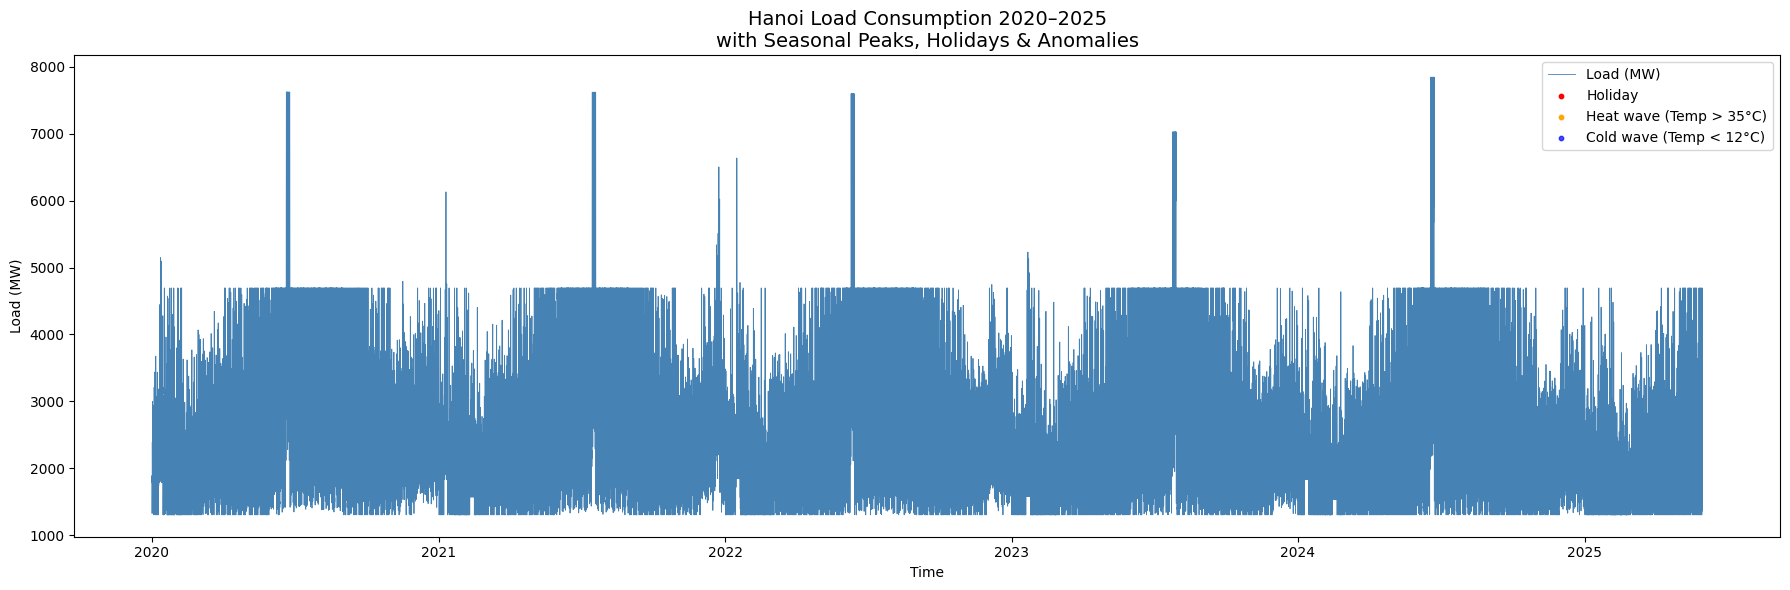

In [11]:
plt.figure(figsize=(18,6))
plt.plot(df.index, df['total_consumption_mw'], color='steelblue', linewidth=0.6, label='Load (MW)')

# Highlight holidays
holiday_points = df[df['is_holiday'] == True]
plt.scatter(holiday_points.index, holiday_points['total_consumption_mw'],
            color='red', s=10, label='Holiday')

# Highlight possible extreme heat events (e.g., Temp > 35°C)
heat_waves = df[df['Temperature'] > 35]
plt.scatter(heat_waves.index, heat_waves['total_consumption_mw'],
            color='orange', s=10, label='Heat wave (Temp > 35°C)')

# Highlight possible cold waves (e.g., Temp < 12°C)
cold_waves = df[df['Temperature'] < 12]
plt.scatter(cold_waves.index, cold_waves['total_consumption_mw'],
            color='blue', s=10, alpha=0.7, label='Cold wave (Temp < 12°C)')

plt.title("Hanoi Load Consumption 2020–2025\nwith Seasonal Peaks, Holidays & Anomalies", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
plt.savefig("Hanoi Load Consumption 2020–2025.png")

<Figure size 640x480 with 0 Axes>

### 2. Weekly profiles in 2022 (Summer vs. Winter)

* **Summer week (July 2022)**:

  * Very pronounced **evening peaks** around 19:00–21:00.
  * Loads exceed 4,500 MW almost every evening, showing cooling demand dominance.
* **Winter week (Jan 2022)**:

  * Lower absolute demand, but **more variable intraday patterns**.
  * Peaks less sharp, possibly tied to heating and lighting, with some morning increases.
* **Takeaway**: intraday patterns differ sharply by season → models must learn both *daily rhythms* and *seasonal shifts*.

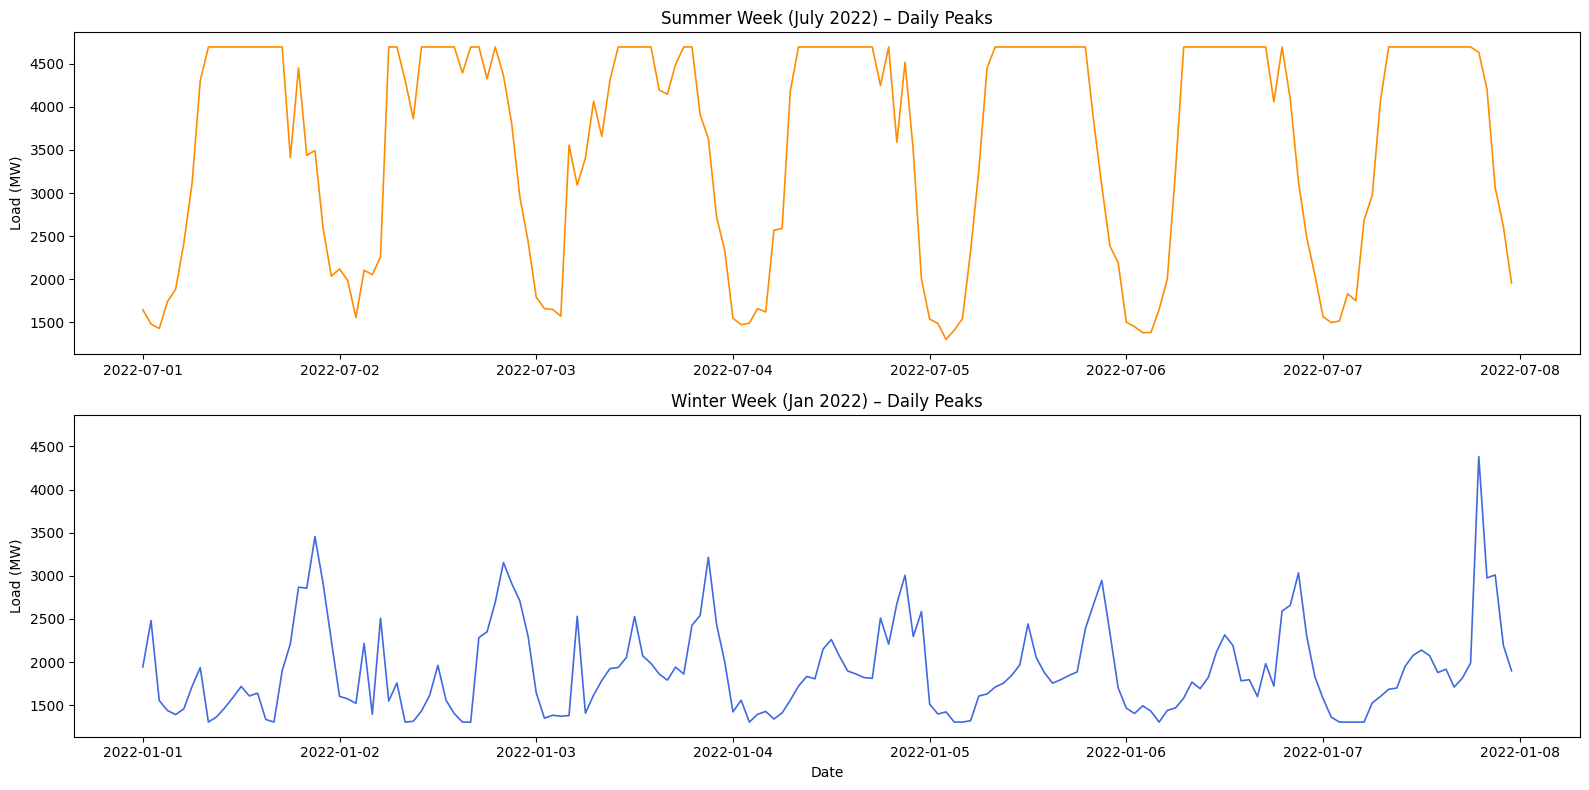

In [6]:
# Make sure timestamp is datetime and index is set
df = df.copy()
df['timestamp'] = pd.to_datetime(df.index)

# Pick one representative week in summer (e.g., July 2022)
summer_week = df.loc['2022-07-01':'2022-07-07']

# Pick one representative week in winter (e.g., January 2022)
winter_week = df.loc['2022-01-01':'2022-01-07']

fig, axes = plt.subplots(2, 1, figsize=(16,8), sharey=True)

# --- Summer plot
axes[0].plot(summer_week['timestamp'], summer_week['total_consumption_mw'],
             color='darkorange', linewidth=1.2)
axes[0].set_title("Summer Week (July 2022) – Daily Peaks")
axes[0].set_ylabel("Load (MW)")

# --- Winter plot
axes[1].plot(winter_week['timestamp'], winter_week['total_consumption_mw'],
             color='royalblue', linewidth=1.2)
axes[1].set_title("Winter Week (Jan 2022) – Daily Peaks")
axes[1].set_ylabel("Load (MW)")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


In [7]:
plt.savefig("Weekly profiles in 2022.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
np.max(df['timestamp'])

Timestamp('2025-05-31 00:00:00')

### 3. Weekly profiles in 2025 (Spring vs. Winter)

* **Spring/early summer (May 2025)**:

  * Peaks around \~4,500–4,700 MW are already visible, showing the ramp-up of cooling loads before the full summer.
  * Daily structure resembles summer (high evening peaks), but slightly lower baseline.
* **Winter (Jan 2025)**:

  * Lower and more fluctuating demand (\~2,000–3,200 MW).
  * Multiple smaller peaks during mornings/evenings → more diffuse usage patterns.
* **Takeaway**: demonstrates how demand is **rising over time** (compare 2022 vs. 2025 summer-type weeks: \~200–300 MW higher on average). This may be due to population growth, urbanization, or higher AC penetration.

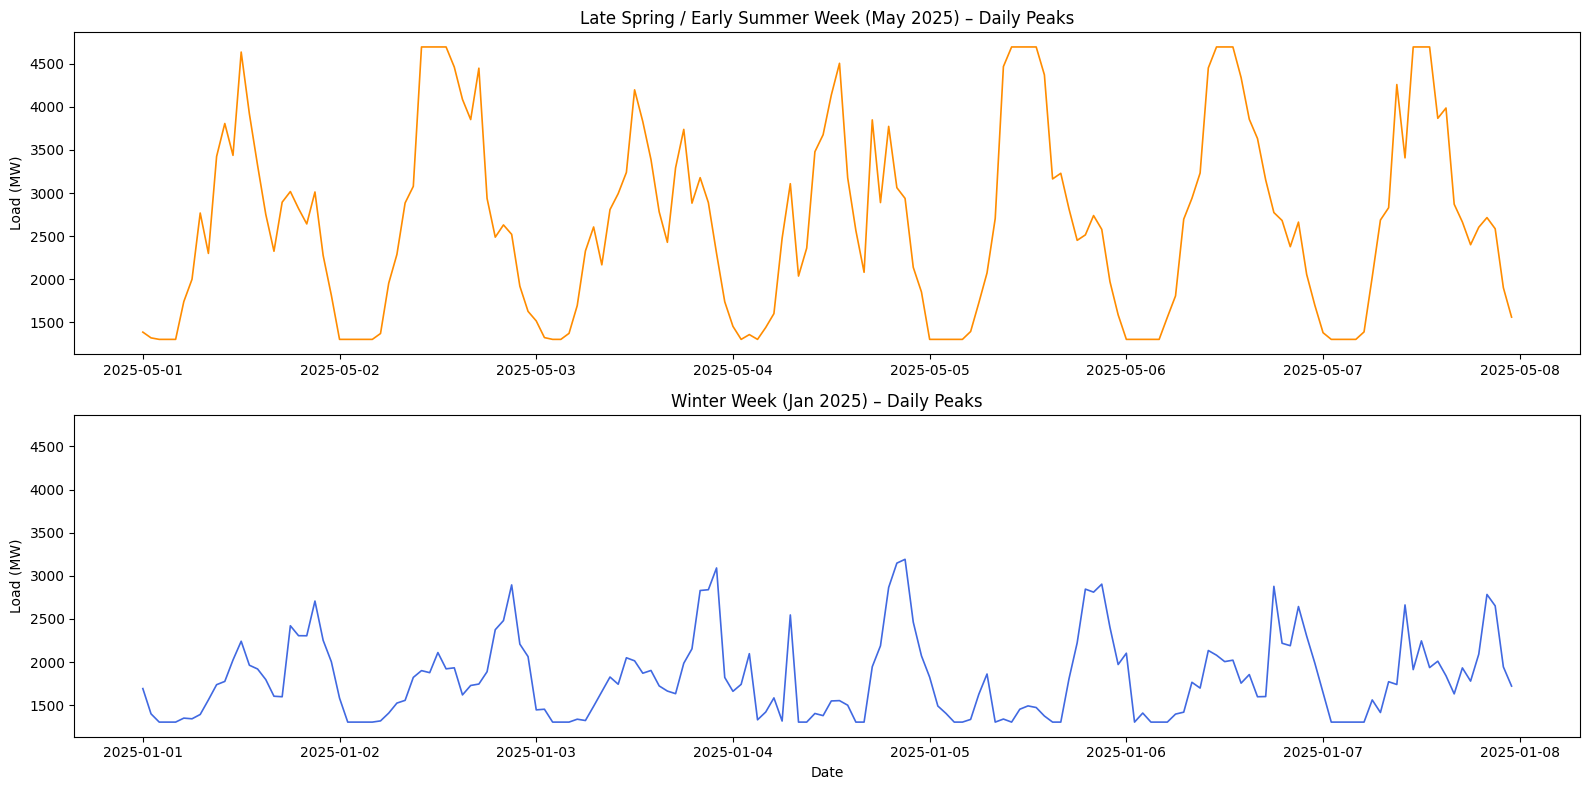

In [8]:
import matplotlib.pyplot as plt

# Ensure timestamp is datetime and index is set
df = df.copy()
df['timestamp'] = pd.to_datetime(df.index)

# Representative winter week (January 2025)
winter_week_2025 = df.loc['2025-01-01':'2025-01-07']

# Representative spring/pre-summer week (May 2025)
spring_week_2025 = df.loc['2025-05-01':'2025-05-07']

fig, axes = plt.subplots(2, 1, figsize=(16,8), sharey=True)

# --- Spring/early-summer plot
axes[0].plot(spring_week_2025['timestamp'], spring_week_2025['total_consumption_mw'],
             color='darkorange', linewidth=1.2)
axes[0].set_title("Late Spring / Early Summer Week (May 2025) – Daily Peaks")
axes[0].set_ylabel("Load (MW)")

# --- Winter plot
axes[1].plot(winter_week_2025['timestamp'], winter_week_2025['total_consumption_mw'],
             color='royalblue', linewidth=1.2)
axes[1].set_title("Winter Week (Jan 2025) – Daily Peaks")
axes[1].set_ylabel("Load (MW)")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


In [9]:
plt.savefig("Weekly profiles in 2025.png")

<Figure size 640x480 with 0 Axes>

### 4. Average demand by hour of day for all days in Jan 2025 (winter) and May 2025 (late spring / early summer).

---

1. **Winter 2025 (blue line)**

   * Demand is relatively flat during the day, hovering around **1,400–1,800 MW** from midnight to afternoon.
   * Sharp **evening peak after 17:00**, climbing to over **3,000 MW by 21:00–22:00**.
   * Pattern reflects **lighting and heating usage**: subdued daytime load, concentrated evening household demand.

2. **Late Spring / Early Summer 2025 (orange line)**

   * Very strong **daytime and early afternoon load**, exceeding **4,000–4,500 MW** around **11:00–14:00**.
   * This is classic **air-conditioning driven demand** in warmer weather.
   * Evening load is still high (\~2,500–3,000 MW), but the biggest stress on the grid occurs in **midday–afternoon**, not at night.

3. **Contrast between seasons**

   * **Different peak hours**: winter peaks in the evening, spring/summer peaks in the early afternoon.
   * **Different load magnitudes**: summer baseline is 1.5–2× higher than winter.
   * This underscores that **forecasting models must adapt to shifting seasonal behaviors**. A single pattern cannot generalize year-round.

---

### Implications for the Project

* **Feature engineering justified**: Including season, temperature, and holiday variables is essential, since the daily shape shifts dramatically.
* **Forecasting challenge**: Models must not only predict “how much load,” but also “when the peak occurs.”
* **Value of known-ahead covariates (Z)**: Weather forecast data (temperature, humidity) are critical — without them, the model may miss the midday summer peaks.
* **Policy relevance**: Results show grid stress periods differ by season (afternoon vs evening). Grid operators need season-specific demand response strategies.

---

This plot is a *perfect figure for the paper’s “Results/Insights” section* because it makes the **seasonal contrast in daily demand structure obvious in one glance**.


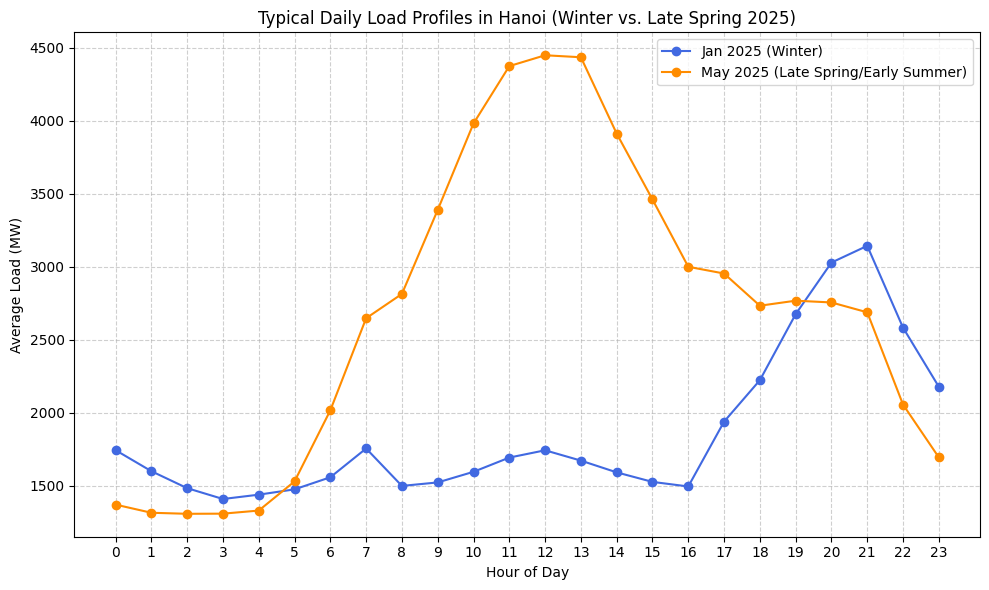

In [13]:
# Ensure timestamp is datetime
df = df.copy()
df['timestamp'] = pd.to_datetime(df.index)

# Extract year, month, hour
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

# Filter for Jan 2025 and May 2025
jan_2025 = df[(df['year'] == 2025) & (df['month'] == 1)]
may_2025 = df[(df['year'] == 2025) & (df['month'] == 5)]

# Group by hour of day and compute mean load
jan_profile = jan_2025.groupby('hour')['total_consumption_mw'].mean()
may_profile = may_2025.groupby('hour')['total_consumption_mw'].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(jan_profile.index, jan_profile.values, marker='o', color='royalblue', label='Jan 2025 (Winter)')
plt.plot(may_profile.index, may_profile.values, marker='o', color='darkorange', label='May 2025 (Late Spring/Early Summer)')

plt.title("Typical Daily Load Profiles in Hanoi (Winter vs. Late Spring 2025)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load (MW)")
plt.xticks(range(0,24))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [14]:
plt.savefig("Typical Daily Load Profiles in Hanoi (Winter vs. Late Spring 2025).png")

<Figure size 640x480 with 0 Axes>

### 5. Multi-Year Evolution of Typical Daily Load Profiles in Hanoi (2020–2025)

This figure is excellent because it captures **how Hanoi’s “typical day” has evolved over 2020–2025**. Here’s how you can comment on it in your paper:

---

1. **2020–2024 profiles (colored lines above brown)**

   * Daily shapes are **remarkably consistent**:

     * Morning ramp-up starting \~06:00.
     * **First peak around 12:00–13:00**, driven by midday cooling and office demand.
     * Afternoon dip \~15:00–17:00, then a **second strong peak at 20:00–21:00** from residential usage.
   * Absolute loads are fairly high (daytime peaks \~3,500–3,800 MW; evening peaks \~3,400–3,600 MW).
   * Small year-to-year variation, but overall trend is stable.

2. **2025 profile (brown line)**

   * Significantly **lower magnitude across all hours** (midday peak \~2,900 MW vs. \~3,800 MW in earlier years).
   * The shape is still recognizable (double-peak structure), but the **intensity dropped** compared to 2020–2024.
   * This drop is not a real demand collapse — it likely reflects **dataset truncation** (ending in May 2025), so the average is biased toward cooler months, missing the high summer demand.

3. **General trends**

   * **Structural stability**: the “double hump” pattern (midday + evening peaks) is very robust across years, reflecting stable daily human/economic activity.
   * **Magnitude variation**: 2020–2024 profiles show slightly higher peaks in earlier years, possibly due to anomalies like extreme heat events or recording inconsistencies.
   * **Seasonal bias** in 2025 makes it appear artificially lower.

---

### Implications for the project

* **Modeling challenge**: Forecasting models must learn both peaks (midday and evening) — missing one leads to underestimation of stress periods.
* **Importance of complete datasets**: Without summer 2025, the apparent drop emphasizes why **consistent temporal coverage** is vital for training robust models.
* **Relevance to feature engineering**: These visualizations justify including *time-of-day* and *seasonal* covariates, since the hourly shape is stable but magnitudes change with external drivers (temperature, holidays, etc.).

---

### How to frame it in your paper

You can write:

> “The multi-year evolution figure shows that Hanoi’s electricity demand follows a stable double-peak daily pattern, with midday office/AC-driven loads and evening residential peaks. While 2025 appears lower due to dataset truncation before summer, the overall stability in shape emphasizes the importance of capturing temporal features such as hour-of-day and season in forecasting models, while weather covariates explain variations in load intensity.”

---


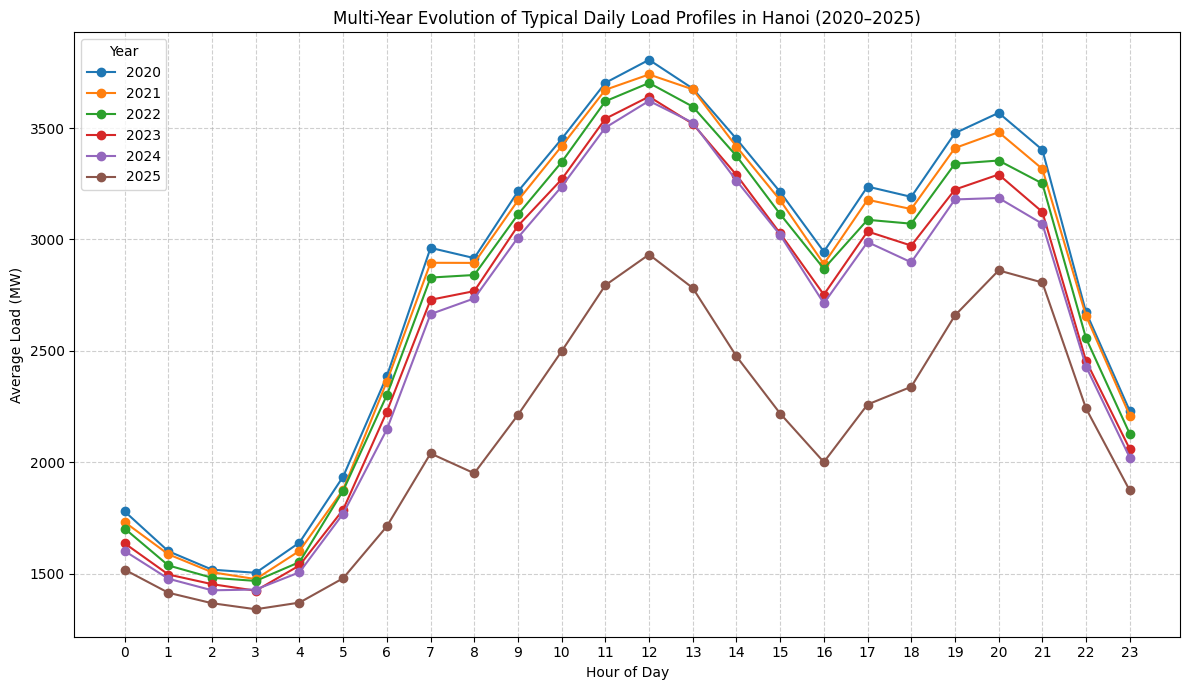

In [15]:
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
df = df.copy()
df['timestamp'] = pd.to_datetime(df.index)

# Extract year and hour
df['year'] = df['timestamp'].dt.year
df['hour'] = df['timestamp'].dt.hour

# Compute mean daily profile for each year
profiles_by_year = df.groupby(['year','hour'])['total_consumption_mw'].mean().reset_index()

plt.figure(figsize=(12,7))

# Plot each year’s profile
for yr in sorted(profiles_by_year['year'].unique()):
    profile = profiles_by_year[profiles_by_year['year'] == yr]
    plt.plot(profile['hour'], profile['total_consumption_mw'], marker='o', linewidth=1.5, label=str(yr))

plt.title("Multi-Year Evolution of Typical Daily Load Profiles in Hanoi (2020–2025)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load (MW)")
plt.xticks(range(0,24))
plt.legend(title="Year", loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [16]:
plt.savefig("Multi-Year Evolution of Typical Daily Load Profiles in Hanoi (2020–2025).png")

<Figure size 640x480 with 0 Axes>

### 6. Residual Seasonal Comparison: Summer – Winter Daily Load Profiles (2020–2024).

This residual seasonal comparison is very powerful because it directly isolates the **net impact of summer vs. winter demand**. Here’s how I’d comment on it:

---

### Observations

1. **Overall shape**

   * From about **06:00 to 19:00**, summer demand exceeds winter demand by a large margin.
   * The difference peaks around **10:00–15:00**, consistently reaching **\~3,000–3,100 MW** across years.
   * Before dawn (0–5h) and late evening (20–23h), the difference is close to zero or slightly negative — showing that winter evenings sometimes have higher loads (heating/lighting).

2. **Year-to-year consistency (2020–2024)**

   * The curves nearly overlap, which confirms that the **seasonal gap is stable in shape**.
   * The fact that all years show a consistent **\~3,000 MW midday gap** demonstrates that cooling demand dominates Hanoi’s seasonal variability.
   * Minor differences across years suggest some inter-annual variability, but the trend is remarkably persistent.

3. **Asymmetry of seasonal impact**

   * Winter demand does not scale up the way summer demand does.
   * The grid is thus **more vulnerable in summer afternoons**, when the additional demand is equivalent to **an extra 2–3 GW** compared to winter.

---

### Implications for your project

* **Modeling**:

  * Forecasting models must prioritize **temperature-sensitive regressors** (e.g., cooling degree days, humidity, temp–humidity interactions), because these explain the summer–winter gap.
  * Hour-of-day effects are crucial: the seasonal difference is concentrated in **daytime hours**, not evenings.

* **Policy/Grid operations**:

  * This figure tells grid operators where the real stress lies: **summer daytime peaks**.
  * Demand response, energy storage, and renewable integration should target these hours.

* **Narrative value in the paper**:

  > “Residual seasonal comparisons show that Hanoi’s summer demand exceeds winter demand by as much as 3 GW during midday hours, while winter evenings show comparable or slightly higher demand. This strongly asymmetric seasonal pattern emphasizes the role of cooling loads in shaping short-term demand, and highlights the importance of incorporating weather-dependent regressors into forecasting models.”

---

This figure is a great candidate to **pair with the feature engineering explanation** (cooling degree days, temp × humidity, etc.), since it visually proves why those features matter.



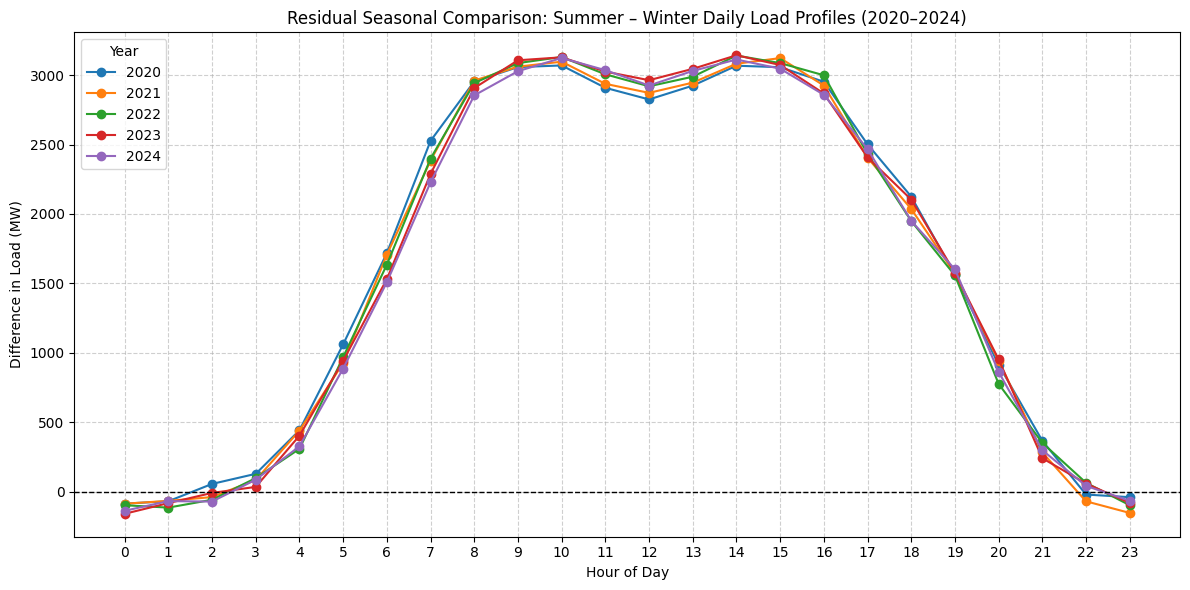

In [17]:
import matplotlib.pyplot as plt

# Ensure datetime handling
df = df.copy()
df['timestamp'] = pd.to_datetime(df.index)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

# Seasonal masks
winter_mask = df['month'].isin([1,2])
summer_mask = df['month'].isin([6,7,8])

# Compute winter & summer profiles
winter_profiles = df[winter_mask].groupby(['year','hour'])['total_consumption_mw'].mean().reset_index()
summer_profiles = df[summer_mask].groupby(['year','hour'])['total_consumption_mw'].mean().reset_index()

# Merge to compute summer - winter difference
residual_profiles = pd.merge(summer_profiles, winter_profiles,
                             on=['year','hour'],
                             suffixes=('_summer','_winter'))
residual_profiles['diff'] = residual_profiles['total_consumption_mw_summer'] - residual_profiles['total_consumption_mw_winter']

# Plot difference curves
plt.figure(figsize=(12,6))
for yr in sorted(residual_profiles['year'].unique()):
    if yr <= 2024:  # skip 2025 (incomplete summer)
        prof = residual_profiles[residual_profiles['year']==yr]
        plt.plot(prof['hour'], prof['diff'], marker='o', linewidth=1.5, label=str(yr))

plt.title("Residual Seasonal Comparison: Summer – Winter Daily Load Profiles (2020–2024)")
plt.xlabel("Hour of Day")
plt.ylabel("Difference in Load (MW)")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(range(0,24))
plt.legend(title="Year", loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [18]:
plt.savefig("Residual Seasonal Comparison: Summer – Winter Daily Load Profiles (2020–2024).png")

<Figure size 640x480 with 0 Axes>

### Optional

/tmp/ipython-input-2765881731.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


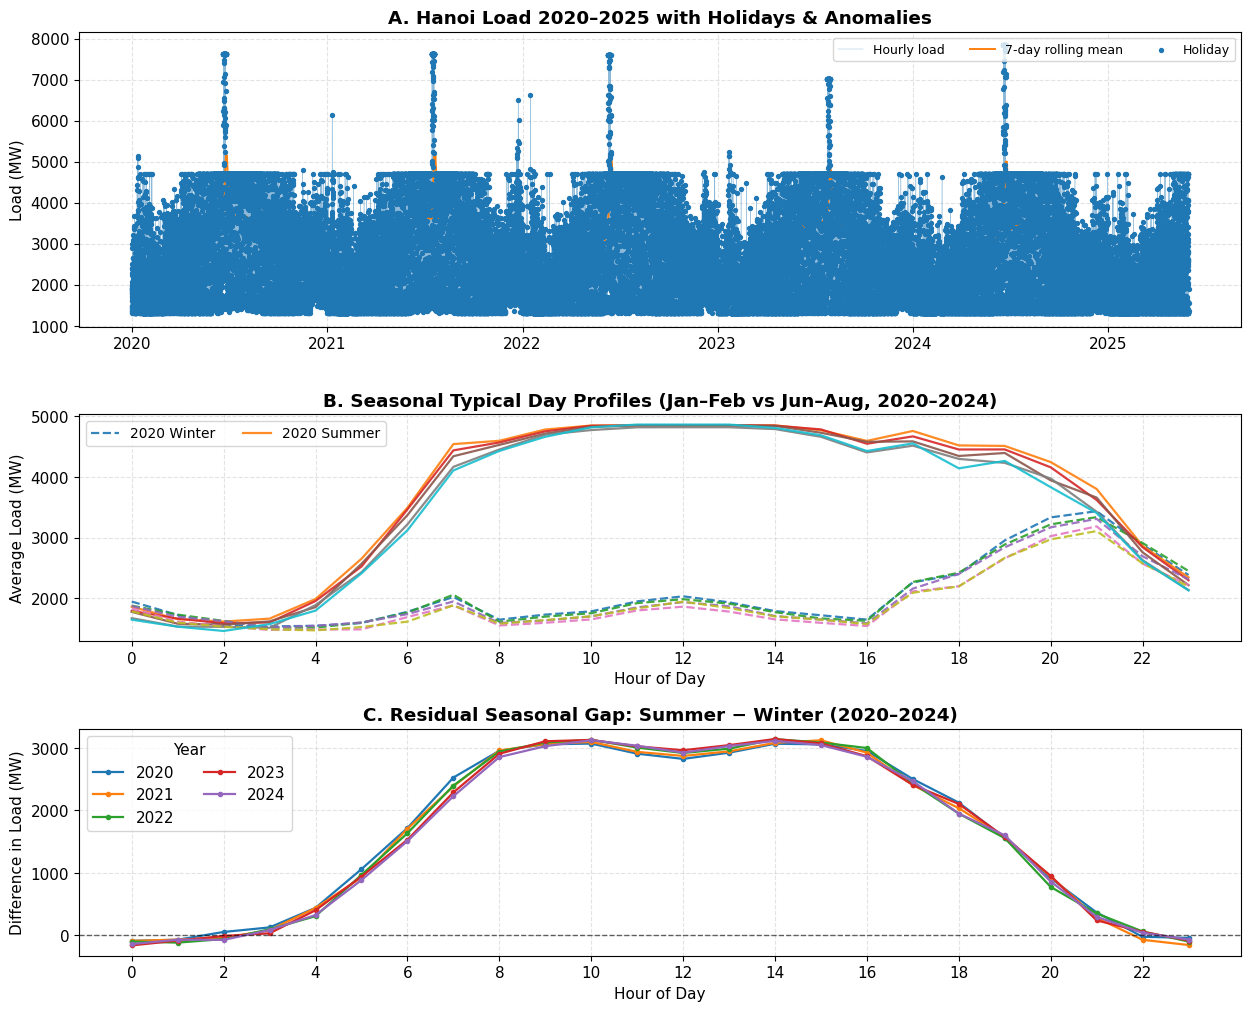

Saved figure: hanoi_stlf_dataset_story_3panel.png


In [ ]:
# --- Compact 3-panel dataset story for the paper ---

# Assumptions:
# - df has columns: 'timestamp', 'total_consumption_mw', 'Temperature', 'is_holiday'
# - df['timestamp'] covers 2020-01-01 to 2025-05-31 (no Jun–Aug 2025)
# - Index may already be timestamp; code handles both.

# ---------- Prep ----------
df_ = df.copy()
if 'timestamp' in df_.columns:
    df_['timestamp'] = pd.to_datetime(df_['timestamp'])
    df_.set_index('timestamp', inplace=True)
else:
    df_.index = pd.to_datetime(df_.index)

df_ = df_.sort_index()
df_['year']  = df_.index.year
df_['month'] = df_.index.month
df_['hour']  = df_.index.hour

# Masks
winter_mask = df_['month'].isin([1,2])
summer_mask = df_['month'].isin([6,7,8])

# Profiles
winter_profiles = (df_[winter_mask]
                   .groupby(['year','hour'])['total_consumption_mw'].mean().reset_index())
summer_profiles = (df_[summer_mask]
                   .groupby(['year','hour'])['total_consumption_mw'].mean().reset_index())

# Residual: Summer - Winter (only years with both seasons present)
residual = pd.merge(summer_profiles, winter_profiles,
                    on=['year','hour'], suffixes=('_summer','_winter'))
residual['diff'] = residual['total_consumption_mw_summer'] - residual['total_consumption_mw_winter']

# ---------- Figure ----------
plt.rcParams.update({
    "font.size": 11,
    "axes.titleweight": "bold",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35
})

fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(3,1, height_ratios=[1.3,1,1], hspace=0.35)

# --- (A) Long-term series with markers + 7-day rolling mean ---
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(df_.index, df_['total_consumption_mw'], lw=0.3, alpha=0.5, label='Hourly load')
ax1.plot(df_.index, df_['total_consumption_mw'].rolling(24*7, min_periods=24).mean(),
         lw=1.4, label='7-day rolling mean')

# Holiday markers
if 'is_holiday' in df_.columns:
    holiday_points = df_.loc[df_['is_holiday'].astype(bool)]
    if not holiday_points.empty:
        ax1.scatter(holiday_points.index, holiday_points['total_consumption_mw'],
                    s=8, label='Holiday', zorder=3)

# Heat / cold markers (tweak thresholds if needed)
if 'Temperature' in df_.columns:
    heat = df_.loc[df_['Temperature'] >= 35]
    cold = df_.loc[df_['Temperature'] <= 12]
    if not heat.empty:
        ax1.scatter(heat.index, heat['total_consumption_mw'], s=8, label='Heat wave (≥35°C)', zorder=3)
    if not cold.empty:
        ax1.scatter(cold.index, cold['total_consumption_mw'], s=8, label='Cold spell (≤12°C)', zorder=3)

ax1.set_title("A. Hanoi Load 2020–2025 with Holidays & Anomalies")
ax1.set_ylabel("Load (MW)")
ax1.legend(ncol=4, fontsize=9, frameon=True, loc='upper right')

# --- (B) Seasonal sliced typical daily profiles (Winter vs Summer) ---
ax2 = fig.add_subplot(gs[1,0])

years = sorted([y for y in df_['year'].unique() if 2020 <= y <= 2024])  # keep 2020–2024
for y in years:
    # Winter dashed
    wp = winter_profiles[winter_profiles['year']==y]
    if not wp.empty:
        ax2.plot(wp['hour'], wp['total_consumption_mw'], ls='--', lw=1.6, alpha=0.9, label=f"{y} Winter" if y==years[0] else None)
    # Summer solid
    sp = summer_profiles[summer_profiles['year']==y]
    if not sp.empty:
        ax2.plot(sp['hour'], sp['total_consumption_mw'], ls='-',  lw=1.6, alpha=0.9, label=f"{y} Summer" if y==years[0] else None)

ax2.set_title("B. Seasonal Typical Day Profiles (Jan–Feb vs Jun–Aug, 2020–2024)")
ax2.set_xlabel("Hour of Day"); ax2.set_ylabel("Average Load (MW)")
ax2.set_xticks(range(0,24,2))
# one compact legend: explain line styles once
ax2.legend(loc='upper left', frameon=True, fontsize=10, ncol=2)

# --- (C) Residual seasonal comparison (Summer − Winter) ---
ax3 = fig.add_subplot(gs[2,0])

for y in years:
    prof = residual[residual['year']==y]
    if not prof.empty:
        ax3.plot(prof['hour'], prof['diff'], marker='o', ms=3, lw=1.6, label=str(y))

ax3.axhline(0, color='black', lw=1, ls='--', alpha=0.6)
ax3.set_title("C. Residual Seasonal Gap: Summer − Winter (2020–2024)")
ax3.set_xlabel("Hour of Day"); ax3.set_ylabel("Difference in Load (MW)")
ax3.set_xticks(range(0,24,2))
ax3.legend(title="Year", loc='upper left', frameon=True, ncol=2)

# Tight layout + save
plt.tight_layout()
plt.savefig("hanoi_stlf_dataset_story_3panel.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: hanoi_stlf_dataset_story_3panel.png")


### Weather variable distributions

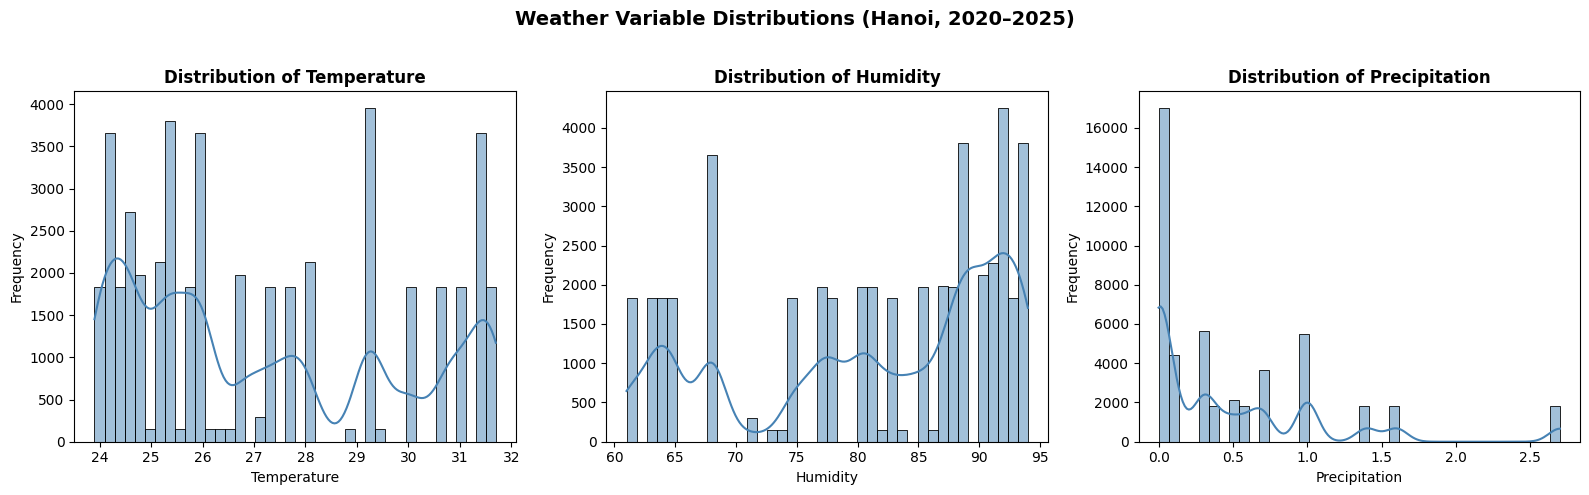

In [19]:
# Pick the key weather variables
weather_vars = ['Temperature', 'Humidity', 'Precipitation']

plt.figure(figsize=(16,5))

for i, col in enumerate(weather_vars, 1):
    ax = plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=40, color='steelblue', ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.suptitle("Weather Variable Distributions (Hanoi, 2020–2025)", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [20]:
plt.savefig("Weather Variable Distributions (Hanoi, 2020–2025).png")

<Figure size 640x480 with 0 Axes>

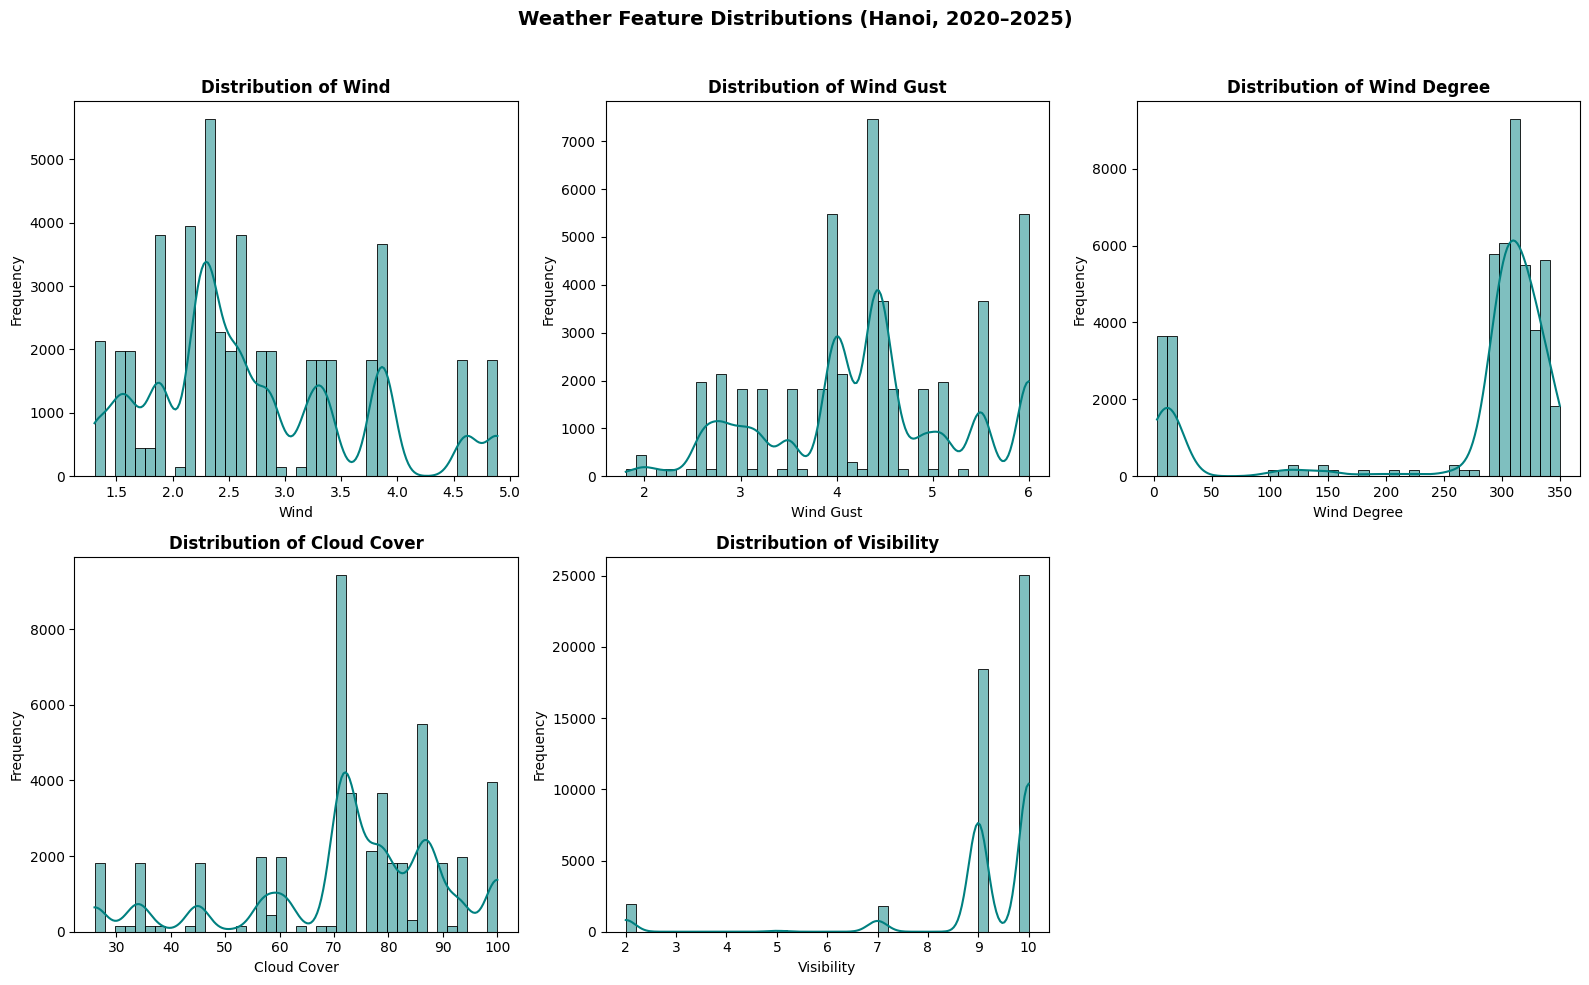

In [21]:
num_cols = ['Wind', 'Wind Gust', 'Wind Degree', 'Cloud Cover', 'Visibility']

plt.figure(figsize=(16,10))

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=40, color='teal', ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.suptitle("Weather Feature Distributions (Hanoi, 2020–2025)", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [22]:
plt.savefig("Weather Feature Distributions (Hanoi, 2020–2025).png")

<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-1345458241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette="viridis", ax=ax)
/tmp/ipython-input-1345458241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette="viridis", ax=ax)
/tmp/ipython-input-1345458241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette="viridis", ax=ax)
/tmp/ipython-input-1345458241.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

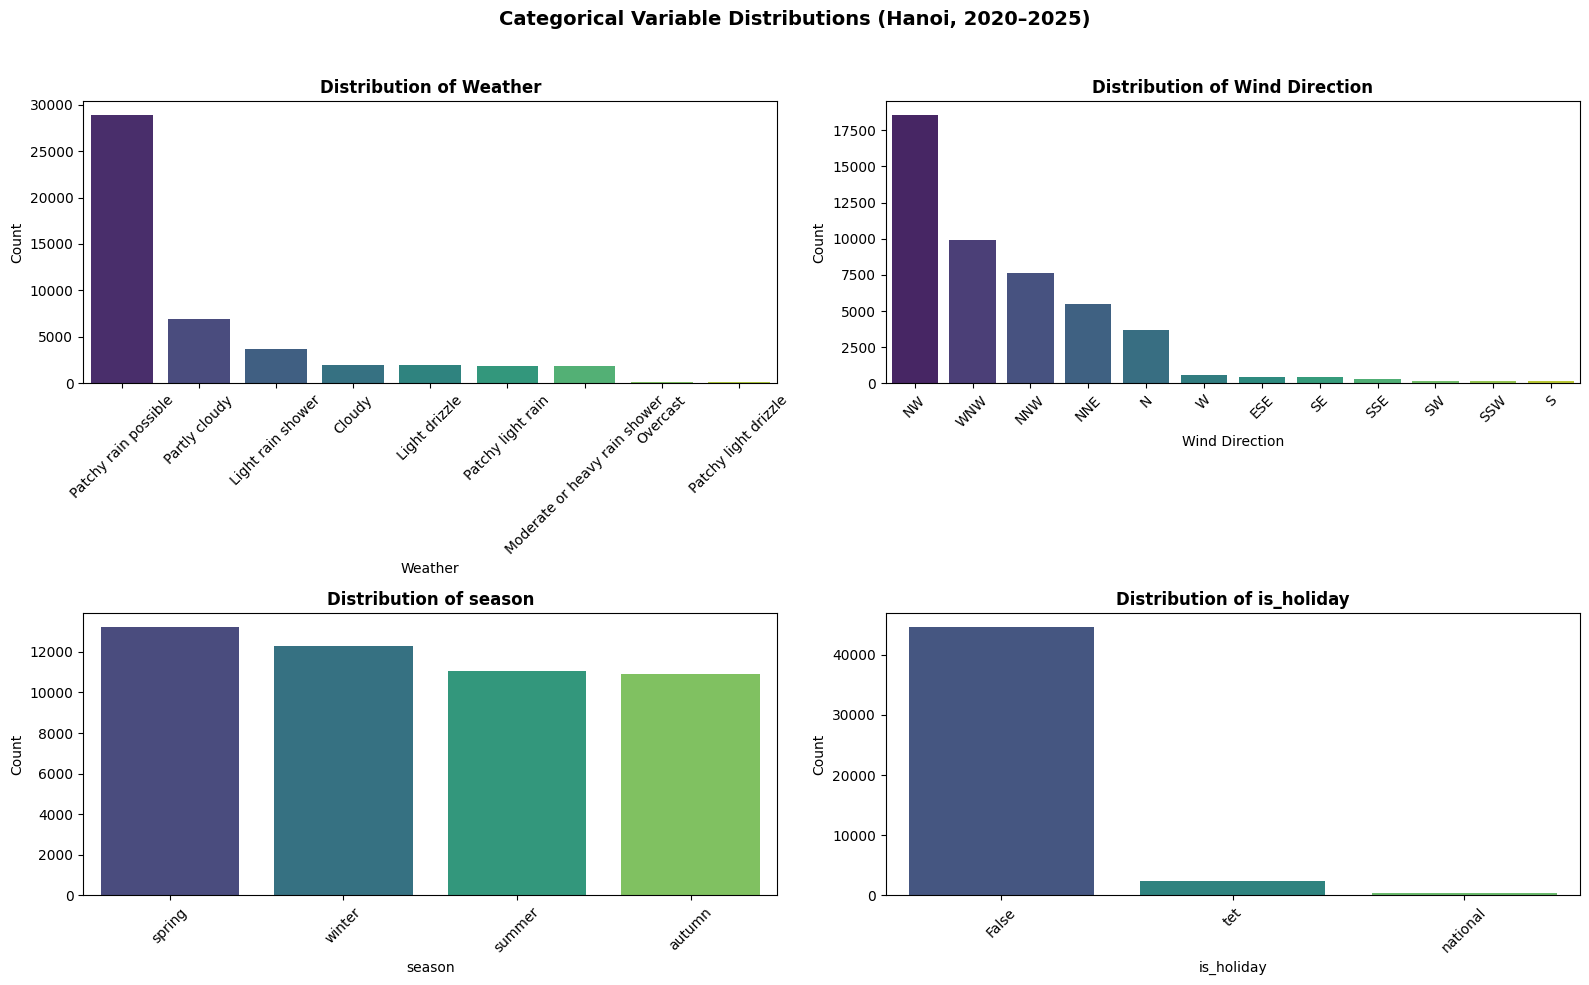

In [23]:
cat_cols = ['Weather', 'Wind Direction', 'season', 'is_holiday']

plt.figure(figsize=(16,10))

for i, col in enumerate(cat_cols, 1):
    ax = plt.subplot(2, 2, i)
    order = df[col].value_counts().index  # sort by frequency
    sns.countplot(data=df, x=col, order=order, palette="viridis", ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Categorical Variable Distributions (Hanoi, 2020–2025)", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [24]:
plt.savefig("Categorical Variable Distributions (Hanoi, 2020–2025).png")

<Figure size 640x480 with 0 Axes>

**Numeric Weather Variables**

* **Temperature**: Clustered mainly around 24–32°C, reflecting Hanoi’s warm, humid subtropical climate. Peaks in summer go above 30°C frequently.
* **Humidity**: Very high overall (70–95%), with a strong concentration at \~85–90%. This explains why heat feels more intense and drives AC demand.
* **Precipitation**: Highly skewed — most hours are dry (near zero), with occasional heavy rainfall events.
* **Wind / Wind Gust**: Generally low (2–5 km/h), with occasional gusts; indicates wind is not a major cooling factor.
* **Wind Degree**: Not uniform — prevailing winds from NW–WNW dominate.
* **Cloud Cover**: Bimodal (clear vs. overcast days most common).
* **Visibility**: High (8–10 km) most of the time, with dips during fog/rain.

---

**Categorical Variables**

* **Weather**: Dominated by *Patchy rain possible*, followed by *Partly cloudy*. Extreme conditions are rare.
* **Wind Direction**: Most common from NW/NNW/WWN, consistent with Vietnam’s monsoon pattern.
* **Season**: Balanced coverage across all four seasons, confirming dataset completeness.
* **is\_holiday**: Vast majority `False`, with a few spikes for Tet and national holidays — these small but important points can cause unusual demand dips.

---

**Implications**

* Hanoi is **hot, humid, and monsoon-driven**, with strong **seasonality in temperature and humidity**.
* **Most hours are dry**, but extreme rain events occur.
* **Holiday events are sparse but critical**, requiring explicit modeling.
* These distributions justify including **temperature, humidity, precipitation, wind, season, and holidays** as covariates in forecasting models.

---



### Correlation heatmap (load vs. weather variables)

Here’s how you can interpret and comment on this correlation heatmap for your paper:

---

### **Key Observations**

1. **Load vs. Temperature (0.51)**

   * Strong positive correlation: as temperature rises, electricity consumption increases significantly.
   * This reflects **air-conditioning demand in Hanoi’s hot summers** — the single strongest driver of load.

2. **Load vs. Humidity (−0.50)**

   * Negative correlation because humidity is strongly inversely correlated with temperature in this dataset (notice the almost perfect −0.99 correlation between Temp & Humidity).
   * Interpretation: humidity alone isn’t the driver; instead, **hot/dry hours coincide with peak load**.

3. **Load vs. Precipitation (0.33)**

   * Moderate positive relationship: rainy conditions keep people indoors, increasing lighting and cooling/heating use.

4. **Other variables**

   * **Wind, Cloud Cover, Visibility**: Very weak correlations with load (|r| < 0.1).
   * **Wind Degree (−0.23)**: Slightly negative, but this reflects seasonal wind patterns rather than direct causal influence.

---

### **Interactions in Weather Variables**

* **Temperature & Humidity (−0.99)**: almost perfectly inverse — hotter periods are drier, colder periods more humid.
* **Temperature & Precipitation (0.66)**: hotter periods often coincide with higher precipitation (monsoon season).
* **Wind & Wind Gust (0.82)**: strongly coupled, as expected.

---

### **Implications for Feature Engineering**

* **Temperature is the dominant feature** for forecasting load — should always be included.
* **Humidity** is not useful alone but may add predictive value in **interaction terms** (e.g., temperature × humidity → “heat index” or discomfort index).
* **Precipitation** can be a secondary regressor.
* **Wind/Cloud/Visibility** contribute little to short-term demand and may be dropped or only used in ensemble feature sets.

---

### **How to frame it in the paper**

> “The correlation analysis shows that temperature has the strongest positive correlation with electricity demand (r ≈ 0.51), confirming cooling load as the primary driver in Hanoi. Humidity exhibits a negative correlation, reflecting its inverse relationship with temperature. Precipitation also shows moderate positive correlation with demand. Other weather factors such as wind, cloud cover, and visibility have weak associations with load, suggesting limited direct predictive power. These insights justify focusing on temperature, precipitation, and composite features (e.g., temperature × humidity) in the feature engineering stage.”

---



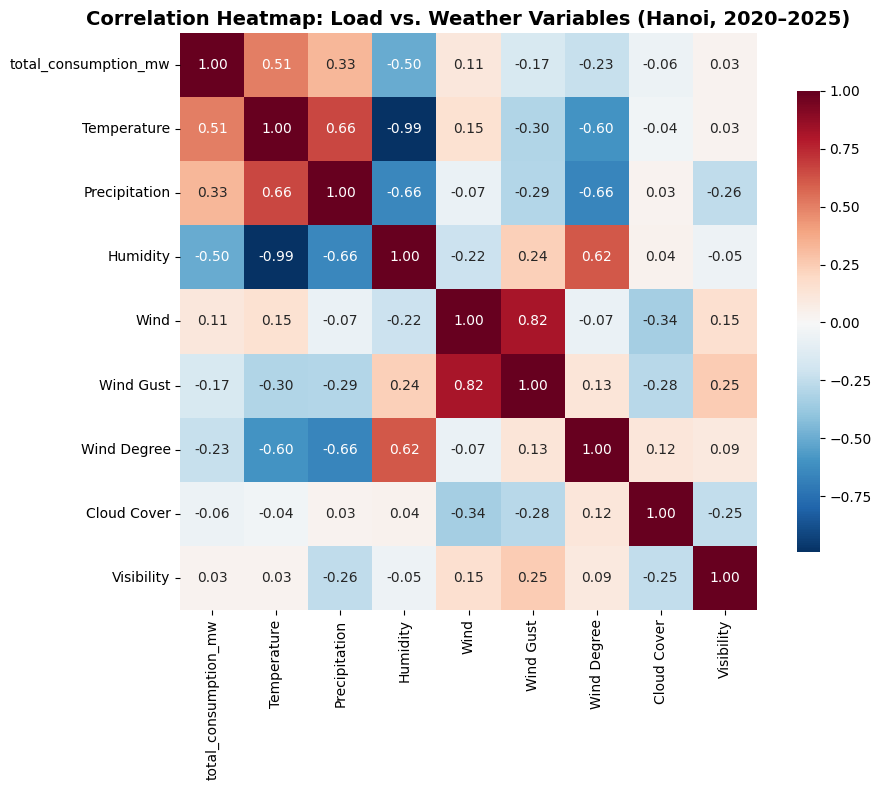

In [25]:
# Select relevant numeric columns
corr_vars = [
    'total_consumption_mw',
    'Temperature','Precipitation','Humidity', 'Wind','Wind Gust','Wind Degree','Cloud Cover','Visibility'
]

# Compute correlation matrix
corr = df[corr_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt=".2f",
            cbar_kws={"shrink": 0.8}, square=True)

plt.title("Correlation Heatmap: Load vs. Weather Variables (Hanoi, 2020–2025)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


In [26]:
plt.savefig("Correlation Heatmap: Load vs. Weather Variables (Hanoi, 2020–2025).png")

<Figure size 640x480 with 0 Axes>

# 4. Feature engineering (leakage-safe)

In [18]:
import os, re, math, warnings
import numpy as np
import pandas as pd
import inspect
import math

warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/duong/STLF/Data/merge_weather_energy_hanoi_20202025_cleaned.csv')
df

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,Visibility,timestamp,is_weekend,season,is_holiday,total_consumption_mw
0,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,89.0,9.0,2020-01-01 00:00:00,0,winter,False,1790.10
1,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,34.0,10.0,2020-01-01 01:00:00,0,winter,False,1452.26
2,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,87.0,10.0,2020-01-01 02:00:00,0,winter,False,1483.75
3,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,71.0,10.0,2020-01-01 03:00:00,0,winter,False,1890.07
4,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,100.0,10.0,2020-01-01 04:00:00,0,winter,False,1371.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,26.8,Partly cloudy,0.0,0.0,84.0,1.888889,3.388889,109.0,ESE,56.0,10.0,2025-05-30 20:00:00,0,spring,False,2449.28
47445,26.5,Partly cloudy,0.0,0.0,86.0,2.388889,4.194444,126.0,SE,52.0,10.0,2025-05-30 21:00:00,0,spring,False,2554.05
47446,26.1,Patchy rain possible,0.0,0.0,88.0,2.388889,4.194444,149.0,SSE,84.0,10.0,2025-05-30 22:00:00,0,spring,False,1895.41
47447,25.6,Patchy rain possible,0.5,0.0,91.0,2.305556,4.111111,152.0,SSE,76.0,9.0,2025-05-30 23:00:00,0,spring,False,1558.67


In [19]:
CAT_COLS   = ['Weather','Wind Direction','season','is_holiday']
EXOG_NUM   = ['Temperature','Precipitation','Humidity',
              'Wind','Wind Gust','Wind Degree','Cloud Cover','Visibility']
HORIZON    = 24                       # forecast t+1…t+24
TARGET_LAGS   = range(1,49)           # lags of target (1…48)
ROLL_WINDOWS  = [3,6,12,24,48]        # rolling windows
EXOG_LAGS     = [0,1,3,6,12,24]       # lags for exogenous vars
TARGET_COL = 'total_consumption_mw'
TIME_COL   = 'timestamp'


In [20]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df.sort_values(TIME_COL).reset_index(drop=True)

In [21]:
# make sure categoricals are strings
for col in CAT_COLS:
    df[col] = df[col].astype(str)

In [22]:
# add calendar/time features
df['hour']      = df[TIME_COL].dt.hour
df['dow']       = df[TIME_COL].dt.dayofweek
df['dom']       = df[TIME_COL].dt.day
df['month']     = df[TIME_COL].dt.month
df['doy']       = df[TIME_COL].dt.dayofyear
df['hour_sin']  = np.sin(2*np.pi*df['hour']/24)
df['hour_cos']  = np.cos(2*np.pi*df['hour']/24)
df['dow_sin']   = np.sin(2*np.pi*df['dow']/7)
df['dow_cos']   = np.cos(2*np.pi*df['dow']/7)
df['doy_sin']   = np.sin(2*np.pi*df['doy']/365.25)
df['doy_cos']   = np.cos(2*np.pi*df['doy']/365.25)


In [23]:
# Feature engineering
# create lagged target features
for L in TARGET_LAGS:
    df[f'y_lag_{L}'] = df[TARGET_COL].shift(L)

# rolling statistics on the target, with one‑step shift to avoid leakage
for W in ROLL_WINDOWS:
    df[f'y_rollmean_{W}'] = df[TARGET_COL].shift(1).rolling(W, min_periods=1).mean()
    df[f'y_rollstd_{W}']  = df[TARGET_COL].shift(1).rolling(W, min_periods=1).std()

# lagged exogenous features
for col in EXOG_NUM:
    for L in EXOG_LAGS:
        df[f'{col}_lag{L}'] = df[col].shift(L)

# multi‑horizon labels
for h in range(1, HORIZON+1):
    df[f'y_t+{h}'] = df[TARGET_COL].shift(-h)

# drop rows with NaNs (from lagging & shifting)no
df_feat = df.dropna().reset_index(drop=True)

df_feat

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,...,y_t+15,y_t+16,y_t+17,y_t+18,y_t+19,y_t+20,y_t+21,y_t+22,y_t+23,y_t+24
0,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,89.0,...,1823.04,1791.94,1878.24,2037.24,2352.93,3209.41,3103.21,2531.59,2117.06,1725.51
1,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,34.0,...,1791.94,1878.24,2037.24,2352.93,3209.41,3103.21,2531.59,2117.06,1725.51,1700.35
2,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,87.0,...,1878.24,2037.24,2352.93,3209.41,3103.21,2531.59,2117.06,1725.51,1700.35,1681.38
3,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,71.0,...,2037.24,2352.93,3209.41,3103.21,2531.59,2117.06,1725.51,1700.35,1681.38,1533.64
4,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,100.0,...,2352.93,3209.41,3103.21,2531.59,2117.06,1725.51,1700.35,1681.38,1533.64,1633.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47372,26.8,Partly cloudy,0.0,0.0,84.0,1.888889,3.388889,109.0,ESE,56.0,...,4694.40,4694.40,4694.40,4070.88,3940.21,3812.26,2823.75,2354.74,2611.58,2449.28
47373,26.5,Partly cloudy,0.0,0.0,86.0,2.388889,4.194444,126.0,SE,52.0,...,4694.40,4694.40,4070.88,3940.21,3812.26,2823.75,2354.74,2611.58,2449.28,2554.05
47374,26.1,Patchy rain possible,0.0,0.0,88.0,2.388889,4.194444,149.0,SSE,84.0,...,4694.40,4070.88,3940.21,3812.26,2823.75,2354.74,2611.58,2449.28,2554.05,1895.41
47375,25.6,Patchy rain possible,0.5,0.0,91.0,2.305556,4.111111,152.0,SSE,76.0,...,4070.88,3940.21,3812.26,2823.75,2354.74,2611.58,2449.28,2554.05,1895.41,1558.67


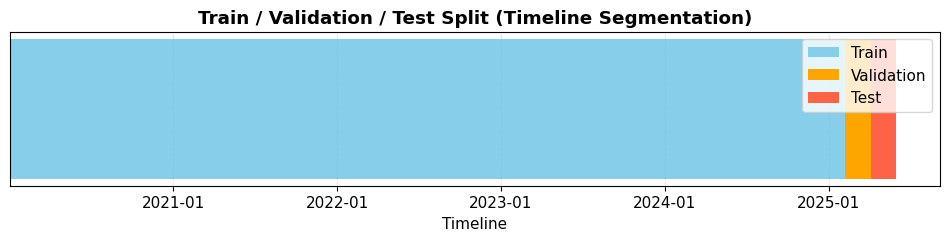

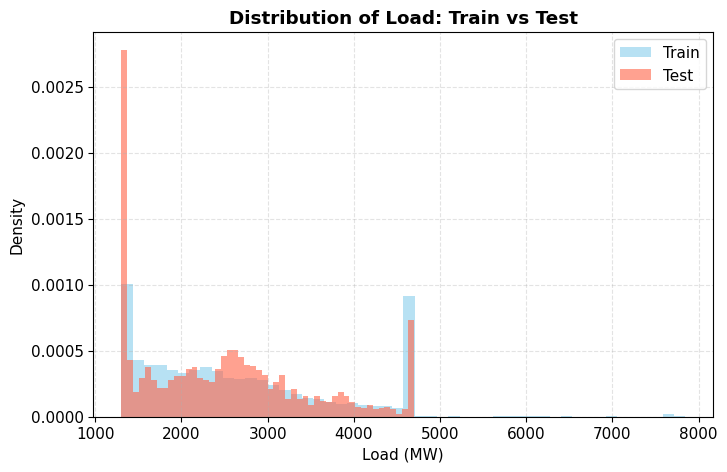

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume df already loaded with datetime index and load column
# Example:
df_copy = df_feat.copy()
df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
df_copy = df_copy.set_index("timestamp")

TARGET_COL = "total_consumption_mw"
N = len(df_feat)
# Define split sizes (example: last 8 weeks = test, previous 8 weeks = validation)
test_size = 8*7*24
val_size  = 8*7*24
train_end = N - (test_size + val_size)
valid_end   = N - test_size

train = df_copy.iloc[:train_end]
valid = df_copy.iloc[train_end:valid_end]
test  = df_copy.iloc[valid_end:]

# -----------------------------
# 1. Timeline segmentation plot
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 2))

ax.barh(y=[0], width=train.index[-1]-train.index[0], left=train.index[0], color="skyblue", label="Train")
ax.barh(y=[0], width=valid.index[-1]-valid.index[0], left=valid.index[0], color="orange", label="Validation")
ax.barh(y=[0], width=test.index[-1]-test.index[0], left=test.index[0], color="tomato", label="Test")

ax.set_yticks([])
ax.set_xlabel("Timeline")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend(loc="upper right")
ax.set_title("Train / Validation / Test Split (Timeline Segmentation)")
plt.show()

# ---------------------------------------
# 2. Distribution comparison (histograms)
# ---------------------------------------
plt.figure(figsize=(8,5))
plt.hist(train[TARGET_COL], bins=50, alpha=0.6, label="Train", density=True, color="skyblue")
plt.hist(test[TARGET_COL], bins=50, alpha=0.6, label="Test", density=True, color="tomato")
plt.xlabel("Load (MW)")
plt.ylabel("Density")
plt.title("Distribution of Load: Train vs Test")
plt.legend()
plt.show()


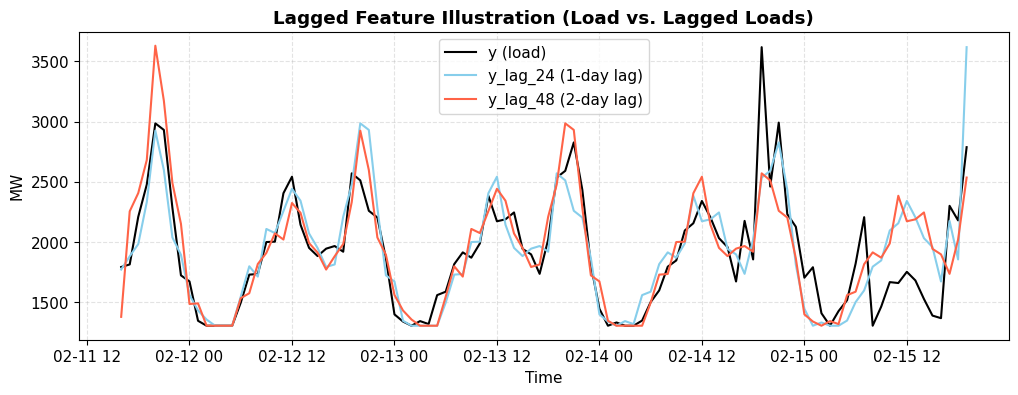

In [31]:
# 1. Lagged features illustration
sample_start = 1000  # pick a slice
sample_end   = 1100
plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL].iloc[sample_start:sample_end],
         df[TARGET_COL].iloc[sample_start:sample_end],
         label="y (load)", color="black")
plt.plot(df[TIME_COL].iloc[sample_start:sample_end],
         df['y_lag_24'].iloc[sample_start:sample_end],
         label="y_lag_24 (1-day lag)", color="skyblue")
plt.plot(df[TIME_COL].iloc[sample_start:sample_end],
         df['y_lag_48'].iloc[sample_start:sample_end],
         label="y_lag_48 (2-day lag)", color="tomato")
plt.title("Lagged Feature Illustration (Load vs. Lagged Loads)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()

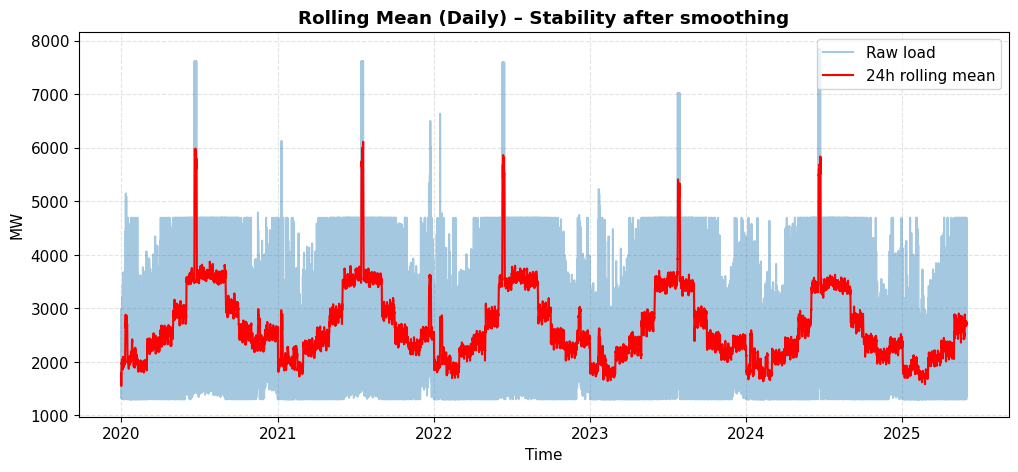

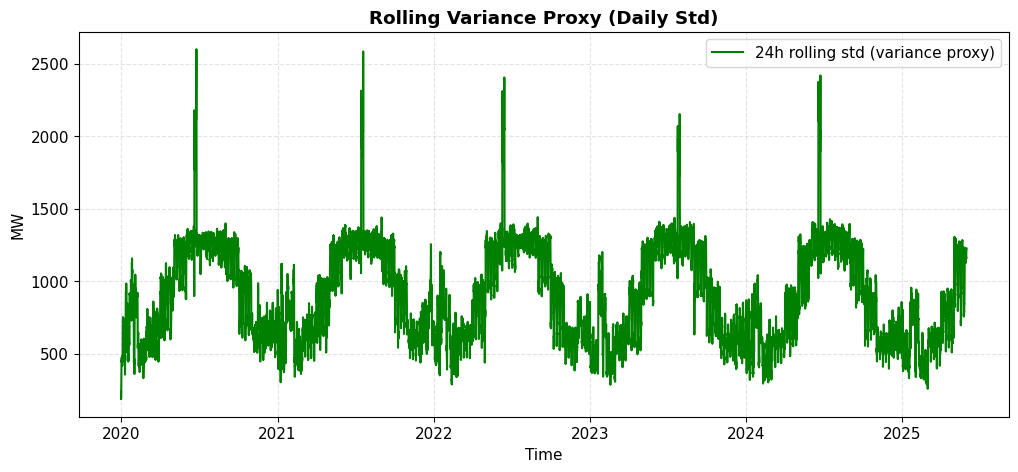

In [32]:
# 2. Rolling mean/variance plots
window = 24  # daily
plt.figure(figsize=(12,5))
plt.plot(df[TIME_COL], df[TARGET_COL], alpha=0.4, label="Raw load")
plt.plot(df[TIME_COL], df['y_rollmean_24'], label="24h rolling mean", color="red")
plt.title("Rolling Mean (Daily) – Stability after smoothing")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df[TIME_COL], df['y_rollstd_24'], label="24h rolling std (variance proxy)", color="green")
plt.title("Rolling Variance Proxy (Daily Std)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()


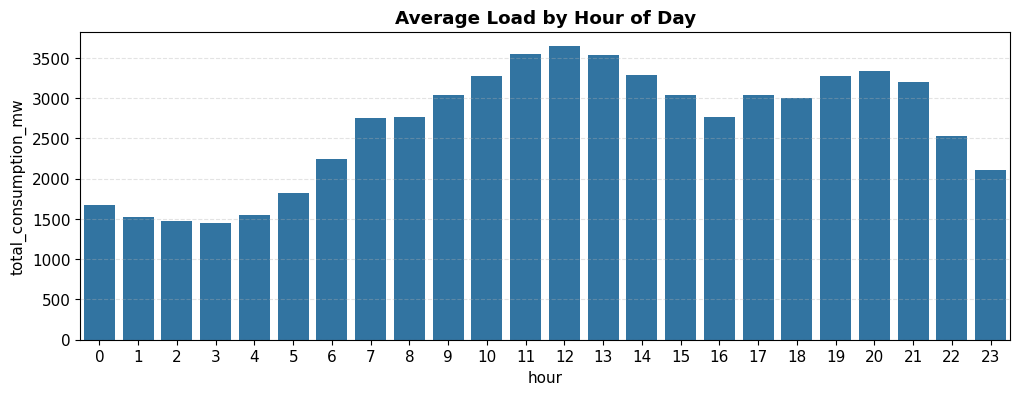

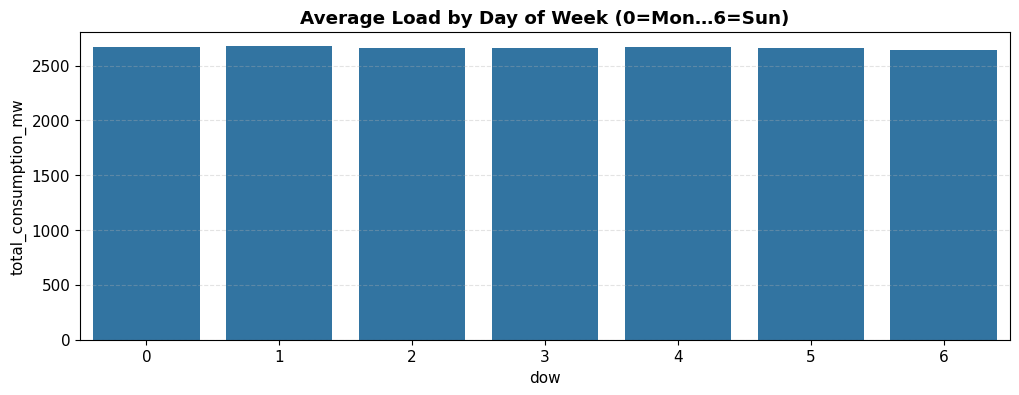

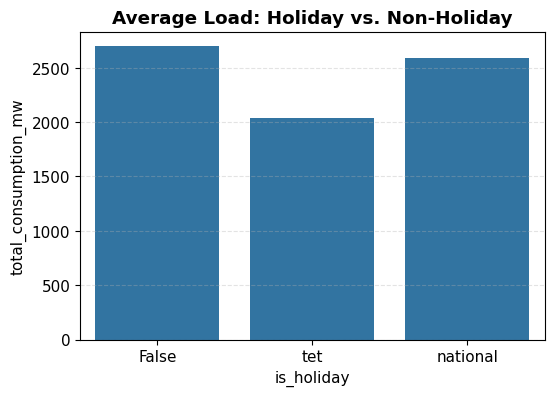

In [33]:
# 3. Calendar effects
plt.figure(figsize=(12,4))
sns.barplot(x="hour", y=TARGET_COL, data=df, estimator=np.mean, ci=None)
plt.title("Average Load by Hour of Day")
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(x="dow", y=TARGET_COL, data=df, estimator=np.mean, ci=None)
plt.title("Average Load by Day of Week (0=Mon…6=Sun)")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x="is_holiday", y=TARGET_COL, data=df, estimator=np.mean, ci=None)
plt.title("Average Load: Holiday vs. Non-Holiday")
plt.show()

In [27]:
# Optional (build future known ahead covariates)
DTYPE = np.float32
# Build Z for EXACT rows in df_feat, then split into train/val/test
def build_future_covariates(times, H, df, TIME_COL):
    df_key = df[[TIME_COL, 'is_holiday', 'season']].copy()
    df_key[TIME_COL] = pd.to_datetime(df_key[TIME_COL])
    df_key = df_key.set_index(TIME_COL).sort_index()

    Z_list = []
    for ts in times:
        row = []
        for h in range(1, H+1):
            t_h = pd.Timestamp(ts) + pd.Timedelta(hours=h)
            hour = t_h.hour; dow = t_h.dayofweek; doy = t_h.dayofyear
            v = [
                np.sin(2*np.pi*hour/24), np.cos(2*np.pi*hour/24),
                np.sin(2*np.pi*dow/7),  np.cos(2*np.pi*dow/7),
                np.sin(2*np.pi*doy/365.25), np.cos(2*np.pi*doy/365.25),
                1 if dow>=5 else 0,  # is_weekend
            ]
            if t_h in df_key.index:
                hol = str(df_key.loc[t_h, 'is_holiday'])
                sea = str(df_key.loc[t_h, 'season'])
            else:
                hol, sea = "False", None
            hol_vec = [int(hol=="False"), int(hol=="tet"), int(hol=="national")]
            sea_vec = [int(sea==s) for s in ["winter","spring","summer","autumn"]] if sea is not None else [0,0,0,0]
            v += hol_vec + sea_vec
            row.append(v)
        Z_list.append(row)
    return np.array(Z_list, dtype=DTYPE)  # (N, H, Ff)

# -- Build & split Z to align with X/Y splits defined above --
end_times_all = df_feat[TIME_COL].values
Z_all = build_future_covariates(end_times_all, HORIZON, df=df, TIME_COL=TIME_COL)

Z_train = Z_all[:train_end]
Z_val   = Z_all[train_end:valid_end]
Z_test  = Z_all[valid_end:]

print(Z_train.shape)
print(Z_val.shape)
print(Z_test.shape)

(44689, 24, 14)
(1344, 24, 14)
(1344, 24, 14)


In [28]:
df.shape

(47449, 157)

In [29]:
df_feat.shape

(47377, 157)

In [30]:
df_feat.to_csv('df_fe.csv', index=False)

# OLD WORK

In [ ]:
# Robust impute for numeric externals BEFORE building lags (so lags won't propagate NaNs)
num_cols_all = [c for c in df_fe.columns if pd.api.types.is_numeric_dtype(df_fe[c]) and c != TARGET]
for c in num_cols_all:
    # time-aware fill then median fallback
    df_fe[c] = df_fe[c].ffill().bfill()
    if df_fe[c].isna().any():
        df_fe[c] = df_fe[c].fillna(df_fe[c].median())
df_fe.isnull().sum()

,0
Temperature,0
Weather,0
Precipitation,0
Chance of snow,0
Humidity,0
Wind,0
Wind Gust,0
Wind Degree,0
Wind Direction,0
Cloud Cover,0


## 4a) Target lags/rollings (use only past values)

In [ ]:
# 4a) Target lags/rollings (use only past values)
def add_target_lags_rollings(frame, ycol, horizon=1):
    out = frame.copy()
    # shift the target to create label at t+h
    out["y_tgt"] = out[ycol].shift(-horizon)   # label: value in the future
    # predictor lags: values strictly before t
    for lag in [1, 24, 168]:
        out[f"y_lag_{lag}"] = out[ycol].shift(lag)
    # rolling stats (past windows)
    for w in [3, 24, 168]:
        out[f"y_rollmean_{w}"] = out[ycol].shift(1).rolling(window=w, min_periods=max(2,int(w/2))).mean()
        out[f"y_rollstd_{w}"]  = out[ycol].shift(1).rolling(window=w, min_periods=max(2,int(w/2))).std()
    return out

df_fe = add_target_lags_rollings(df_fe, TARGET, FORECAST_HORIZON_H)
df_fe.head()

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,...,y_tgt,y_lag_1,y_lag_24,y_lag_168,y_rollmean_3,y_rollstd_3,y_rollmean_24,y_rollstd_24,y_rollmean_168,y_rollstd_168
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,89.0,...,1452.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,34.0,...,1483.75,1790.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,87.0,...,1890.07,1452.26,NaN,NaN,1621.180000,238.888955,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,71.0,...,1371.23,1483.75,NaN,NaN,1575.370000,186.626993,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,100.0,...,1324.10,1890.07,NaN,NaN,1608.693333,244.187482,NaN,NaN,NaN,NaN


## 4b) Choose top weather drivers on TRAIN ONLY, then add their lags/rollings

In [ ]:
# First build a temporary pre-split frame to get train mask
df_tmp = df_fe.reset_index()
mask_train = df_tmp["timestamp"] <= TRAIN_END
mask_val   = (df_tmp["timestamp"] > TRAIN_END) & (df_tmp["timestamp"] <= VAL_END)
mask_test  = (df_tmp["timestamp"] > VAL_END) & (df_tmp["timestamp"] <= TEST_END)

# candidate exogenous numeric features (exclude target and derived target stats)
exclude_prefixes = ("y_lag_","y_rollmean_","y_rollstd_")
candidate_exog = [
    c for c in df_fe.columns
    if (c != TARGET) and
       (not c.startswith(exclude_prefixes)) and
       pd.api.types.is_numeric_dtype(df_fe[c])
]
# Compute absolute correlation (train window) with future label y_tgt to pick top drivers
train_corr = []
train_df = df_tmp.loc[mask_train].set_index("timestamp")
for c in candidate_exog:
    if c == "y_tgt":  # skip the label itself
        continue
    s = train_df[[c, "y_tgt"]].dropna()
    if len(s) < 100:  # need enough overlap
        continue
    corr = s[c].corr(s["y_tgt"])
    if not np.isnan(corr):
        train_corr.append((c, abs(corr)))
train_corr.sort(key=lambda x: x[1], reverse=True)

# take top K=10 exogenous drivers for lags/rollings (tune as needed)
TOPK = 10
top_exog = [c for c,_ in train_corr[:TOPK]]

# now add lags/rollings for those exogenous features (no leakage)
for c in top_exog:
    df_fe[f"{c}_lag1"]   = df_fe[c].shift(1)
    df_fe[f"{c}_lag24"]  = df_fe[c].shift(24)
    df_fe[f"{c}_roll24"] = df_fe[c].shift(1).rolling(window=24, min_periods=12).mean()

In [ ]:
df_fe.head()

,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,Cloud Cover,...,Wind_roll24,sin_hour_lag1,sin_hour_lag24,sin_hour_roll24,sin_doy_lag1,sin_doy_lag24,sin_doy_roll24,Wind Degree_lag1,Wind Degree_lag24,Wind Degree_roll24
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,34.0,...,NaN,0.000000,NaN,NaN,0.017202,NaN,NaN,295.0,NaN,NaN
2020-01-01 02:00:00,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,87.0,...,NaN,0.258819,NaN,NaN,0.017202,NaN,NaN,297.0,NaN,NaN
2020-01-01 03:00:00,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,71.0,...,NaN,0.500000,NaN,NaN,0.017202,NaN,NaN,309.0,NaN,NaN
2020-01-01 04:00:00,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,100.0,...,NaN,0.707107,NaN,NaN,0.017202,NaN,NaN,325.0,NaN,NaN


## 4c) Clip extreme outliers in engineered predictors (not the label)

In [ ]:
# 4c) Clip extreme outliers in engineered predictors (numeric only, not the label)
from pandas.api.types import is_numeric_dtype

# only numeric feature columns (skip label & future label)
predictor_cols_num = [
    c for c in df_fe.columns
    if c not in [TARGET, "y_tgt"] and is_numeric_dtype(df_fe[c])
]

# (optional) ensure float to avoid integer extension dtype quirks
df_fe[predictor_cols_num] = df_fe[predictor_cols_num].astype("float64")

q_low  = df_fe[predictor_cols_num].quantile(0.005)   # already numeric-only
q_high = df_fe[predictor_cols_num].quantile(0.995)

# align quantiles to columns so broadcasting works column-wise
q_low  = q_low.reindex(predictor_cols_num)
q_high = q_high.reindex(predictor_cols_num)

df_fe[predictor_cols_num] = df_fe[predictor_cols_num].clip(
    lower=q_low, upper=q_high, axis=1
)


In [ ]:
# Which columns were NON-numeric and thus skipped?
predictor_cols = [c for c in df_fe.columns if c not in [TARGET, "y_tgt"]]
non_numeric = [c for c in predictor_cols if not pd.api.types.is_numeric_dtype(df_fe[c])]
print("Skipped non-numeric columns:", non_numeric)

Skipped non-numeric columns: ['Weather', 'Wind Direction', 'season', 'is_holiday']


In [ ]:
df_fe = df_fe.reset_index()

# 5. Split & prepare matrices

In [ ]:
df_fe

,timestamp,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Wind Direction,...,Wind_roll24,sin_hour_lag1,sin_hour_lag24,sin_hour_roll24,sin_doy_lag1,sin_doy_lag24,sin_doy_roll24,Wind Degree_lag1,Wind Degree_lag24,Wind Degree_roll24
0,2020-01-01 00:00:00,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,WNW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,WNW,...,NaN,0.000000,NaN,NaN,0.017202,NaN,NaN,295.0,NaN,NaN
2,2020-01-01 02:00:00,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,NW,...,NaN,0.258819,NaN,NaN,0.017202,NaN,NaN,297.0,NaN,NaN
3,2020-01-01 03:00:00,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,NW,...,NaN,0.500000,NaN,NaN,0.017202,NaN,NaN,309.0,NaN,NaN
4,2020-01-01 04:00:00,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,NNW,...,NaN,0.707107,NaN,NaN,0.017202,NaN,NaN,325.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,2025-05-30 20:00:00,26.8,Partly cloudy,0.0,0.0,84.0,1.888889,3.388889,109.0,ESE,...,2.128472,-0.965926,-0.866025,-9.251859e-18,0.532227,0.546711,0.534641,102.0,109.0,227.875
47445,2025-05-30 21:00:00,26.5,Partly cloudy,0.0,0.0,86.0,2.388889,4.194444,126.0,SE,...,2.128472,-0.866025,-0.707107,-9.251859e-18,0.532227,0.546711,0.534038,109.0,126.0,227.875
47446,2025-05-30 22:00:00,26.1,Patchy rain possible,0.0,0.0,88.0,2.388889,4.194444,149.0,SSE,...,2.128472,-0.707107,-0.500000,-9.251859e-18,0.532227,0.546711,0.533434,126.0,149.0,227.875
47447,2025-05-30 23:00:00,25.6,Patchy rain possible,0.5,0.0,91.0,2.305556,4.111111,152.0,SSE,...,2.128472,-0.500000,-0.258819,-9.251859e-18,0.532227,0.546711,0.532831,149.0,152.0,227.875


In [ ]:
# --- Patch for non-numeric predictors ---
import re

# 2) Wind Direction -> degrees + sin/cos (drop raw column afterwards)
def parse_wdir_deg(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().upper()

    # numeric like "220", "220°", "220 deg"
    m = re.search(r"(-?\d+(?:\.\d+)?)", s)
    if m:
        return float(m.group(1)) % 360.0

    # cardinal/ordinal (16-wind)
    s = s.replace("-", "").replace(" ", "")
    compass = {
        "N":0, "NNE":22.5, "NE":45, "ENE":67.5, "E":90, "ESE":112.5,
        "SE":135, "SSE":157.5, "S":180, "SSW":202.5, "SW":225, "WSW":247.5,
        "W":270, "WNW":292.5, "NW":315, "NNW":337.5
    }
    return compass.get(s, np.nan)

if "Wind Direction" in df_fe.columns:
    wdir_str = df_fe["Wind Direction"].astype(str)          # <-- no longer categorical
    deg = wdir_str.map(parse_wdir_deg).astype("float64")    # <-- numeric
    df_fe["wind_dir_deg"] = deg

    # compute cyclic encodings on a NumPy float array (not a categorical series)
    rad = np.deg2rad(deg.to_numpy(dtype="float64"))
    df_fe["wind_dir_sin"] = np.sin(rad)
    df_fe["wind_dir_cos"] = np.cos(rad)

    # optional: impute NaNs produced by unrecognized directions
    df_fe[["wind_dir_sin","wind_dir_cos"]] = df_fe[["wind_dir_sin","wind_dir_cos"]].fillna(0.0)

    # drop raw text to avoid accidental one-hot explosion
    df_fe.drop(columns=["Wind Direction"], inplace=True, errors="ignore")

df_fe

,timestamp,Temperature,Weather,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Cloud Cover,...,sin_hour_roll24,sin_doy_lag1,sin_doy_lag24,sin_doy_roll24,Wind Degree_lag1,Wind Degree_lag24,Wind Degree_roll24,wind_dir_deg,wind_dir_sin,wind_dir_cos
0,2020-01-01 00:00:00,25.4,Patchy rain possible,0.6,0.0,89.0,2.194444,4.388889,295.0,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.5,-0.923880,0.382683
1,2020-01-01 01:00:00,25.1,Partly cloudy,0.0,0.0,90.0,2.611111,5.111111,297.0,34.0,...,NaN,0.017202,NaN,NaN,295.0,NaN,NaN,292.5,-0.923880,0.382683
2,2020-01-01 02:00:00,24.7,Patchy rain possible,0.0,0.0,91.0,2.805556,5.500000,309.0,87.0,...,NaN,0.017202,NaN,NaN,297.0,NaN,NaN,315.0,-0.707107,0.707107
3,2020-01-01 03:00:00,24.5,Cloudy,0.0,0.0,92.0,2.611111,4.888889,325.0,71.0,...,NaN,0.017202,NaN,NaN,309.0,NaN,NaN,315.0,-0.707107,0.707107
4,2020-01-01 04:00:00,24.1,Patchy rain possible,0.0,0.0,93.0,2.305556,4.000000,326.0,100.0,...,NaN,0.017202,NaN,NaN,325.0,NaN,NaN,337.5,-0.382683,0.923880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,2025-05-30 20:00:00,26.8,Partly cloudy,0.0,0.0,84.0,1.888889,3.388889,109.0,56.0,...,-9.251859e-18,0.532227,0.546711,0.534641,102.0,109.0,227.875,112.5,0.923880,-0.382683
47445,2025-05-30 21:00:00,26.5,Partly cloudy,0.0,0.0,86.0,2.388889,4.194444,126.0,52.0,...,-9.251859e-18,0.532227,0.546711,0.534038,109.0,126.0,227.875,135.0,0.707107,-0.707107
47446,2025-05-30 22:00:00,26.1,Patchy rain possible,0.0,0.0,88.0,2.388889,4.194444,149.0,84.0,...,-9.251859e-18,0.532227,0.546711,0.533434,126.0,149.0,227.875,157.5,0.382683,-0.923880
47447,2025-05-30 23:00:00,25.6,Patchy rain possible,0.5,0.0,91.0,2.305556,4.111111,152.0,76.0,...,-9.251859e-18,0.532227,0.546711,0.532831,149.0,152.0,227.875,157.5,0.382683,-0.923880


In [ ]:
df_fe.to_csv("df_fe.csv", index=False)

In [ ]:
type(df_fe.loc[0, "timestamp"])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
mask_train = df_fe["timestamp"] <= TRAIN_END
mask_val   = (df_fe["timestamp"] > TRAIN_END) & (df_fe["timestamp"] <= VAL_END)
mask_test  = (df_fe["timestamp"] > VAL_END) & (df_fe["timestamp"] <= TEST_END)

train_df = df_fe.loc[mask_train].copy()
val_df   = df_fe.loc[mask_val].copy()
test_df  = df_fe.loc[mask_test].copy()

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((35064, 66), (8784, 66), (3601, 66))

In [ ]:
# Drop any rows where label is NaN (due to horizon shift)
for part in (train_df, val_df, test_df):
    part.dropna(subset=["y_tgt"], inplace=True)

train_df.shape, val_df.shape, test_df.shape

((35064, 66), (8784, 66), (3600, 66))

In [ ]:
# Identify features
y_train, y_val, y_test = train_df["y_tgt"].values, val_df["y_tgt"].values, test_df["y_tgt"].values

In [ ]:
# Categorical columns (season + any remaining objects)
cat_cols = ['season', 'Weather', 'is_holiday']

In [ ]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47449 entries, 0 to 47448
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             47449 non-null  datetime64[ns]
 1   Temperature           47449 non-null  float64       
 2   Weather               47449 non-null  category      
 3   Precipitation         47449 non-null  float64       
 4   Chance of snow        47449 non-null  float64       
 5   Humidity              47449 non-null  float64       
 6   Wind                  47449 non-null  float64       
 7   Wind Gust             47449 non-null  float64       
 8   Wind Degree           47449 non-null  float64       
 9   Cloud Cover           47449 non-null  float64       
 10  Visibility            47449 non-null  float64       
 11  is_weekend            47449 non-null  float64       
 12  season                47449 non-null  category      
 13  is_holiday      

In [ ]:
# Numeric predictors = all engineered/normalized predictors (except label, timestamp)
X_cols = [
    c for c in df_fe.columns
    if c not in ["timestamp", TARGET, "y_tgt"] + cat_cols
]
num_cols = [c for c in X_cols if pd.api.types.is_numeric_dtype(df_fe[c])]

X_train = train_df[num_cols + cat_cols]
X_val   = val_df[num_cols + cat_cols]
X_test  = test_df[num_cols + cat_cols]

X_train.shape, X_val.shape, X_test.shape

((35064, 63), (8784, 63), (3600, 63))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((35064,), (8784,), (3600,))

In [ ]:
df_fe.loc[1, "total_consumption_mw"]

np.float64(1452.26)

In [ ]:
y_train[0]

np.float64(1452.26)

In [ ]:
X_train

,Temperature,Precipitation,Chance of snow,Humidity,Wind,Wind Gust,Wind Degree,Cloud Cover,Visibility,is_weekend,...,sin_doy_roll24,Wind Degree_lag1,Wind Degree_lag24,Wind Degree_roll24,wind_dir_deg,wind_dir_sin,wind_dir_cos,season,Weather,is_holiday
0,25.4,0.6,0.0,89.0,2.194444,4.388889,295.0,89.0,9.0,0.0,...,NaN,NaN,NaN,NaN,292.5,-0.923880,0.382683,winter,Patchy rain possible,False
1,25.1,0.0,0.0,90.0,2.611111,5.111111,297.0,34.0,10.0,0.0,...,NaN,295.0,NaN,NaN,292.5,-0.923880,0.382683,winter,Partly cloudy,False
2,24.7,0.0,0.0,91.0,2.805556,5.500000,309.0,87.0,10.0,0.0,...,NaN,297.0,NaN,NaN,315.0,-0.707107,0.707107,winter,Patchy rain possible,False
3,24.5,0.0,0.0,92.0,2.611111,4.888889,325.0,71.0,10.0,0.0,...,NaN,309.0,NaN,NaN,315.0,-0.707107,0.707107,winter,Cloudy,False
4,24.1,0.0,0.0,93.0,2.305556,4.000000,326.0,100.0,10.0,0.0,...,NaN,325.0,NaN,NaN,337.5,-0.382683,0.923880,winter,Patchy rain possible,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,27.3,0.1,0.0,81.0,1.305556,2.611111,309.0,87.0,10.0,1.0,...,-0.007884,323.0,309.0,265.25,315.0,-0.707107,0.707107,winter,Patchy rain possible,False
35060,26.8,1.0,0.0,83.0,1.611111,3.194444,320.0,86.0,9.0,1.0,...,-0.007167,309.0,320.0,265.25,315.0,-0.707107,0.707107,winter,Patchy rain possible,False
35061,26.0,0.7,0.0,87.0,1.888889,3.888889,323.0,71.0,9.0,1.0,...,-0.006451,320.0,323.0,265.25,315.0,-0.707107,0.707107,winter,Patchy rain possible,False
35062,25.8,0.5,0.0,88.0,2.194444,4.388889,307.0,71.0,9.0,1.0,...,-0.005734,323.0,307.0,265.25,315.0,-0.707107,0.707107,winter,Patchy rain possible,False


# 6. Preprocess and fit model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mape(y_true, y_pred, eps=1e-6):
    return float(np.mean(np.abs((y_true - y_pred)/np.maximum(np.abs(y_true), eps))) * 100.0)

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    out = np.where(denom==0, 0, 2.0*np.abs(y_pred - y_true)/denom)
    return float(np.mean(out) * 100.0)

rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))  # negate for "higher is better"


In [ ]:
# Categorical = any object/category columns (exclude timestamp & label)
cat_cols = [c for c in trval_df.columns
            if c not in ["timestamp", "y_tgt"]
            and (str(trval_df[c].dtype) in ["object", "category"])]


In [ ]:
trval_df = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

In [ ]:
# Categorical = any object/category columns (exclude timestamp & label)
cat_cols = [c for c in trval_df.columns
            if c not in ["timestamp", "y_tgt"]
            and (str(trval_df[c].dtype) in ["object", "category"])]
cat_cols

['Weather', 'season', 'is_holiday']

In [ ]:
# Numeric = everything else except timestamp & label & cats
num_cols = [c for c in trval_df.columns
            if c not in ["timestamp", "y_tgt"] + cat_cols
            and pd.api.types.is_numeric_dtype(trval_df[c])]

X_trval = trval_df[num_cols + cat_cols]
y_trval = trval_df["y_tgt"].values

X_test  = test_df[num_cols + cat_cols]
y_test  = test_df["y_tgt"].values


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

tscv = TimeSeriesSplit(n_splits=5)

## XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb_pipe = Pipeline([
    ("pre", pre),
    ("model", XGBRegressor(
        random_state=42,
        n_estimators=2000,      # large-ish; no early stopping in CV
        tree_method="hist",
        n_jobs=-1
    ))
])

xgb_grid = {
    "model__learning_rate": [0.02, 0.05, 0.1],
    "model__max_depth": [6, 8, 10],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__reg_lambda": [0.0, 1.0, 5.0],
    # optionally tune min_child_weight:
    "model__min_child_weight": [1, 5, 10],
}

xgb_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_grid,
    scoring=rmse_scorer,     # minimize RMSE
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
xgb_search.fit(X_trval, y_trval)

print("XGB best RMSE (CV):", -xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

# Refit best model on ALL train+val, then evaluate on test
xgb_best = xgb_search.best_estimator_
yhat_test_xgb = xgb_best.predict(X_test)

print({
    "XGB_Test_RMSE": rmse(y_test, yhat_test_xgb),
    "XGB_Test_MAE":  mean_absolute_error(y_test, yhat_test_xgb),
    "XGB_Test_MAPE%": mape(y_test, yhat_test_xgb),
    "XGB_Test_sMAPE%": smape(y_test, yhat_test_xgb),
    "XGB_Test_R2":   r2_score(y_test, yhat_test_xgb),
})

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


KeyboardInterrupt: 